In [1]:
import angle_extraction as aex
import cv2
import matplotlib.pyplot as plt
import numpy as np
import scipy,os
from scipy.optimize import minimize

Final fit:
 Center: (821.160439, 674.368559)
 Radius: 338.006616
 RMS residual: 0.423559
 Points kept: 77, removed: 22


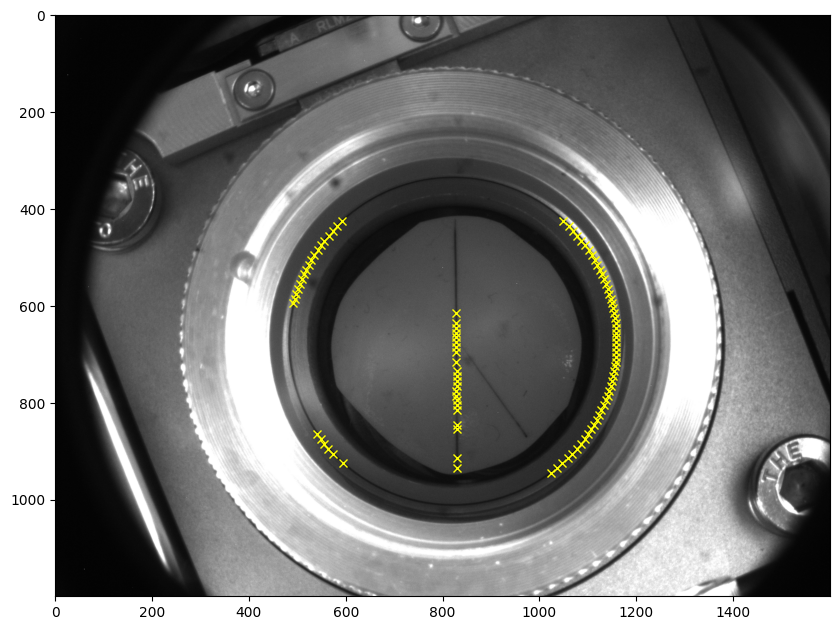

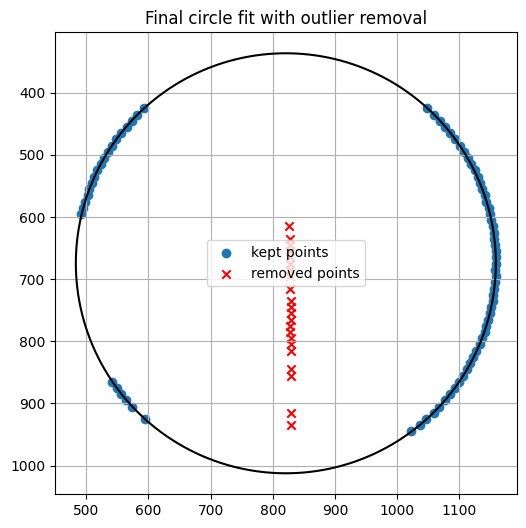

In [2]:
img_number="00023"

image_file_name=f"C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\Image{img_number}.BMP"

image = cv2.imread(image_file_name)

gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

edges= aex.horizontal_edges(gray_image, resolution=10, plot=1, verbose=False)

if len(edges)>2:
    center_info =aex.Center_Radius_iterations(edges, plot=True, verbose=True)

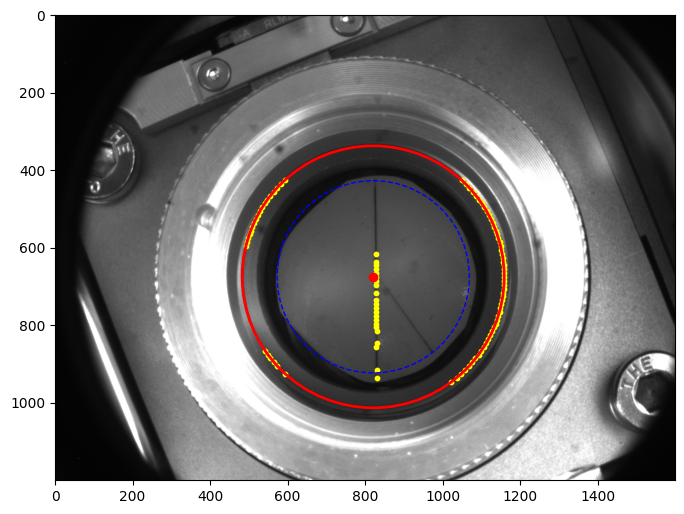

In [3]:
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))   
ax.scatter(edges[:,0], edges[:,1], color='yellow', s=10, label='Detected Edges')

cx, cy, r, rms = center_info[:4]
circle = plt.Circle((cx, cy), r, color='red', fill=False, linewidth=2, label='Fitted Circle')
ax.add_artist(circle)

inner_circle_rad=   r-90
inner_circle = plt.Circle((cx, cy), inner_circle_rad, color='blue',
                          fill=False, linestyle='--', linewidth=1, label='Inner Boundary')


ax.add_artist(inner_circle)
ax.plot(cx, cy, 'ro', label='Circle Center')

In [6]:
#hard coded values to define the image and other parameters
H_limit_hard = [int(cx-inner_circle_rad), int(cx+inner_circle_rad)]
V_limit_hard = [int(cy-inner_circle_rad), int(cy+inner_circle_rad)]

Vertical_limits = [int(cy-r),int(cy+r)]
Horizontal_limits = [int(cx-r),int(cx+r)]

In [ ]:
def horizontal_scan_for_center_peaks(image, resolution=10, center_info=None, plot=1, verbose=False):
    
    #check if image is color or grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    if center_info is None:
        print("No center info provided.")
        edges=aex.horizontal_edges(gray_image, resolution=resolution, plot=0, verbose=False)
        center_info =aex.Center_Radius_iterations(edges, plot=False, verbose=False)

    cx, cy, r, rms = center_info[:4]
    inner_circle_rad=   r-95
    H_limit = [int(cx-inner_circle_rad), int(cx+inner_circle_rad)]
    V_limit = [int(cy-inner_circle_rad), int(cy+inner_circle_rad)]

    Horizontal_limits = [int(cx-r),int(cx+r)]
    Vertical_limits = [int(cy-r),int(cy+r)]
    

    if plot:
      fig,ax = plt.subplots(figsize=(10,4))
      ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      ax.plot(cx, cy, 'ro', label='Circle Center')
      inner_circle = plt.Circle((cx, cy), inner_circle_rad, color='blue',
                          fill=False, linestyle='--', linewidth=1, label='Inner Boundary')
      ax.add_artist(inner_circle) 
      ax.grid()


    All_peaks = []
    # start scanning lines
    for j,y in enumerate(range(V_limit[0],V_limit[1], resolution)):

        # if j >=5:
        #     break
        if verbose:
            print(f"Line {j} at y={y}")

        full_scan = np.max(gray_image[y, :])-gray_image[y,:]

        # calculate left and right limits for the line scan useing circle equation

        square_diff =(np.ceil(inner_circle_rad**2) - (np.floor(y - cy))**2)
        if square_diff <= 0:
            
            if verbose:
                # print(f"Line {j} at y={y} - outside inner circle")
                y1=y
                y = int(cy - inner_circle_rad)+2
                square_diff =(np.ceil(inner_circle_rad**2) - (np.floor(y - cy))**2)
                print(f"y ={y1}, outside, setting y to inside inner circle, {y}")
                
            # continue

        left_most = int(cx - np.sqrt(square_diff))
        right_most = int(cx + np.sqrt(square_diff))
        line_scan = full_scan.copy()
        left_value =line_scan[left_most+2]
        right_value=line_scan[right_most-2]
        endcap_avg = (float(left_value)+float(right_value))/2.0
        print("left and right values",left_value,right_value)
        print("endcap avg",endcap_avg)

        line_scan[:left_most]  = line_scan[left_most+2]
        line_scan[right_most:] = line_scan[right_most-2]
        print("left and right most",left_most,right_most)
        



        #smoothing algorithm parameters
        # window_length must be odd and less than or equal to the size of line_scan

        line_scan_diff = np.gradient(full_scan )
        line_scan_diff[:left_most+20]  = 0
        line_scan_diff[right_most-20:] = 0

        # print("line scan diff ::10",line_scan_diff[::10])

        print("max diff",np.max(line_scan_diff), " min diff", np.min(line_scan_diff))
        print("Std dev", np.std(line_scan_diff))

        
        window_length = 41
        polyorder = 6

        if np.std(line_scan_diff) < 1.3:
            window_length = 11
            polyorder = 6
        elif np.std(line_scan_diff) < 2:
            window_length = 31
            polyorder = 5
        elif np.std(line_scan_diff) < 3:
            window_length = 35
            polyorder = 4
        elif np.std(line_scan_diff) >= 3:
            window_length = 41
            polyorder = 3


        # line_scan_diff = np.diff(line_scan,5)
        # #normalize the diff to fit yell on plot 50-150
        # line_scan_diff = np.clip(line_scan_diff, 50, 150)

        smooth_scan = scipy.signal.savgol_filter(line_scan,
                        window_length=window_length, 
                        polyorder=polyorder)


        
        

        if plot:
            ax.hlines(y, H_limit[0], H_limit[1],
                    colors='red', linestyles='dashed', linewidth=1)

        
        
        if plot > 1:
            
            fig2,ax2 = plt.subplots(figsize=(10,4))
            ax2.vlines(left_most, 0, np.max(line_scan),
                    colors='red', linestyles='dashed', linewidth=1, label='Left Limit')
            ax2.vlines(right_most, 0, np.max(line_scan),
                    colors='orange', linestyles='dashed', linewidth=1, label='Right Limit')
            ax2.plot(line_scan, color="blue",label=f'Line {j} at y={y}')
            ax2.plot(smooth_scan, color="green",label='Smoothed Scan')
            ax2.plot(line_scan_diff, color="purple",label='Line Scan Diff')
            ax2.hlines(endcap_avg, 0, len(line_scan),
                    colors='black', linestyles='dashed', linewidth=1, label='End Cap Avg')
            ax2.grid() 
            ax2.legend()
            ax2.set_xlim(Horizontal_limits)

        peaks=[]
        #wip find a way to adjust the peak finding parameters based 
        #on resolution or other factors


        peaks,peak_props = scipy.signal.find_peaks(smooth_scan,
                                                width=[3,200],
                                                prominence=12,
                                                threshold=0.01,
                                                    height=endcap_avg)
        if len(peaks) > 0:
            if plot > 1:
                ax2.scatter(peaks, line_scan[peaks], color='red', s=50, marker="x", label='Detected Peaks')

        #check to see if any peaks are very close to the left or right limits, use the peak ips
        if len(peaks)>0:
            if abs(peaks[0]-left_most)<12:
                if verbose:
                    print(f"  Removing peak at {peaks[0]} - too close to left limit {left_most}")
                peaks=peaks[1:]
                peak_props={key: peak_props[key][1:] for key in peak_props}  # Update peak_props accordingly
            if len(peaks)>0 and abs(peaks[-1]-right_most)<12:
                if verbose:
                    print(f"  Removing peak at {peaks[-1]} - too close to right limit {right_most}")
                peaks=peaks[:-1]
                peak_props={key: peak_props[key][:-1] for key in peak_props}  # Update peak_props accordingly
            # check for prominence/width ratio
            prominences = peak_props['prominences']
            widths = peak_props['widths']
            squat_ratio = prominences/widths
            print(squat_ratio)
            #drop peaks that have a squat ratio < 1.3
            valid_peaks_mask = squat_ratio >= 1.2
            peaks = peaks[valid_peaks_mask]
            peak_props = {key: peak_props[key][valid_peaks_mask] for key in peak_props}

            #print("squat_ratio",squat_ratio)



        if verbose:
            if len(peaks) == 0:
                print(f"  No peaks found")
            else:
                print(f"  Found {len(peaks)} peaks at x-positions: {peaks}") 
                for key in peak_props:
                    print(f"    {key}: {peak_props[key]}")  


        if len(peaks) > 0:
            if plot > 1:
                ax2.scatter(peaks, line_scan[peaks], color='red', s=50, label='Detected Peaks')
            if plot >= 1:    
                ax.scatter(peaks, np.full_like(peaks, y), color='cyan', s=20, label='Detected Peaks')

        #If more then two peaks are found pick the best two based on prominence
        if len(peaks) > 2:
            prominences = peak_props['prominences']
            top_two_indices = np.argsort(prominences)[-2:]
            peaks = peaks[top_two_indices]





        All_peaks.append(np.column_stack((peaks, np.full_like(peaks, y))))

    return np.vstack(All_peaks)
            

Using image file: C:\Users\Jason.Bane\Documents\Nautilus\DOE_stage\code_trials\images\Image__2025-09-30__10-41-15.bmp
No center info provided.
Line 0 at y=455
y =455, outside, setting y to inside inner circle, 457
left and right values 244 223
endcap avg 233.5
left and right most 768 818
max diff 12.5  min diff -5.5
Std dev 0.4516977522359393
[4.83786117 5.88716874]
  Found 2 peaks at x-positions: [797 806]
    peak_heights: [236.61456191 237.5705471 ]
    left_thresholds: [3.98724805 2.89962978]
    right_thresholds: [0.25339367 9.60798026]
    prominences: [17.05964624 21.54956808]
    left_bases: [784 784]
    right_bases: [801 812]
    widths: [3.52627859 3.66042983]
    width_heights: [228.08473879 226.79576306]
    left_ips: [795.15882084 804.21855994]
    right_ips: [798.68509943 807.87898977]
Line 1 at y=465
left and right values 240 76
endcap avg 158.0
left and right most 726 860
max diff 23.5  min diff -23.0
Std dev 2.0059378407851405
  No peaks found
Line 2 at y=475
left and

C:\Users\Jason.Bane\AppData\Local\Temp\ipykernel_2916\4274451535.py:124: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2,ax2 = plt.subplots(figsize=(10,4))


Line 30 at y=755
left and right values 70 78
endcap avg 74.0
left and right most 554 1032
max diff 12.0  min diff -29.0
Std dev 2.1428190398398086
  Removing peak at 1024 - too close to right limit 1032
[3.90115456]
  Found 1 peaks at x-positions: [865]
    peak_heights: [123.62013401]
    left_thresholds: [0.67585161]
    right_thresholds: [0.7305615]
    prominences: [56.27017098]
    left_bases: [640]
    right_bases: [879]
    widths: [14.42397889]
    width_heights: [95.48504852]
    left_ips: [857.7483295]
    right_ips: [872.17230839]
Line 31 at y=765
left and right values 61 114
endcap avg 87.5
left and right most 556 1030
max diff 24.5  min diff -25.0
Std dev 2.37077749641336
[3.82455357]
  Found 1 peaks at x-positions: [881]
    peak_heights: [124.83855203]
    left_thresholds: [1.32815136]
    right_thresholds: [0.29127455]
    prominences: [52.34442715]
    left_bases: [624]
    right_bases: [948]
    widths: [13.68641496]
    width_heights: [98.66633846]
    left_ips: [874

array([[797, 457],
       [806, 457],
       [602, 585],
       [617, 595],
       [634, 605],
       [649, 615],
       [664, 625],
       [679, 635],
       [694, 645],
       [712, 655],
       [725, 665],
       [741, 675],
       [774, 695],
       [788, 705],
       [803, 715],
       [819, 725],
       [834, 735],
       [850, 745],
       [865, 755],
       [881, 765],
       [897, 775],
       [912, 785],
       [929, 795],
       [945, 805],
       [963, 815],
       [977, 825]])

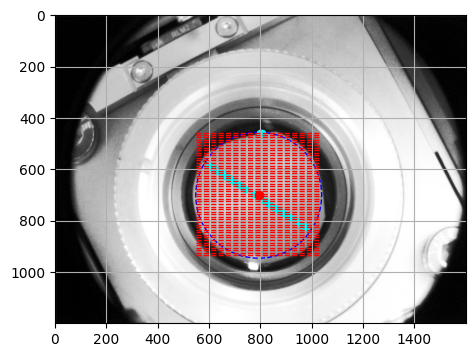

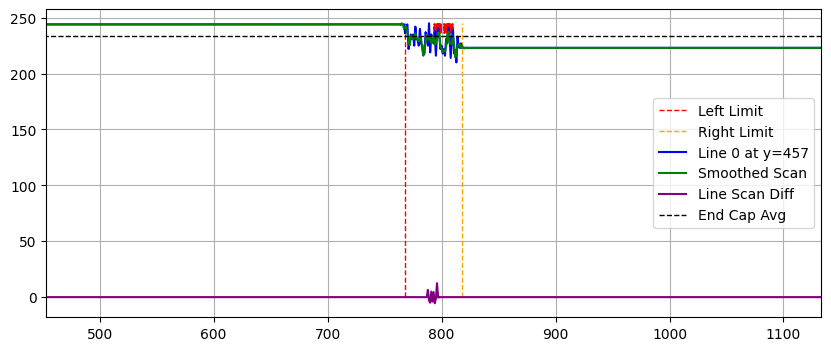

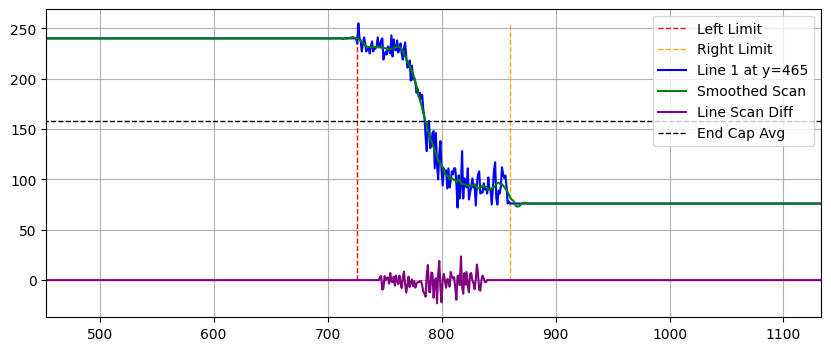

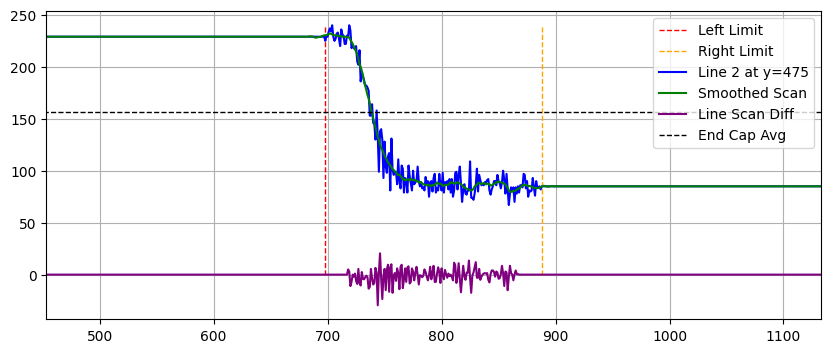

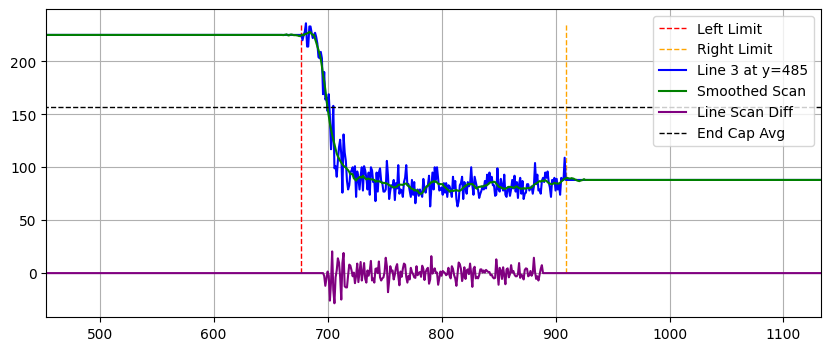

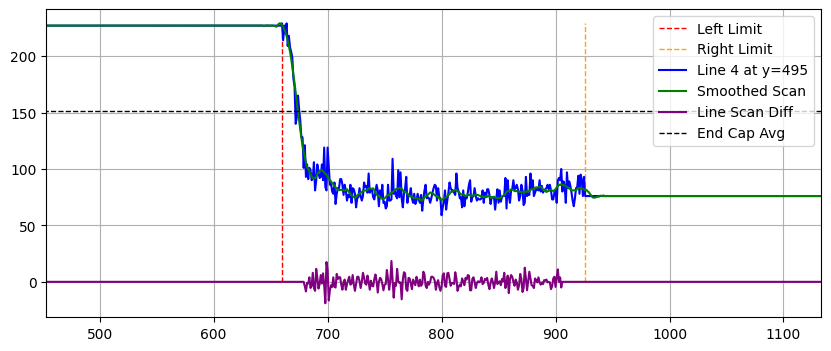

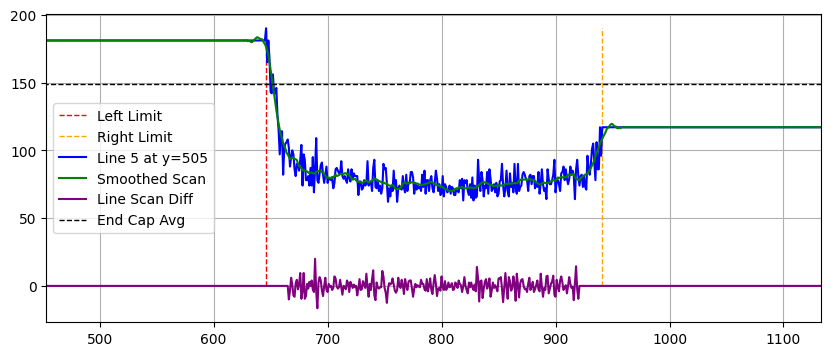

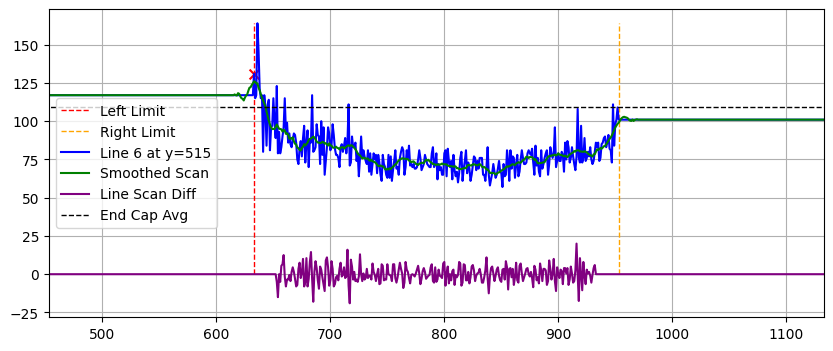

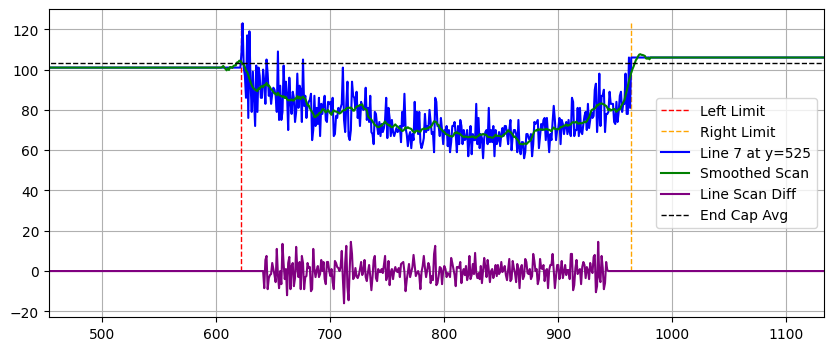

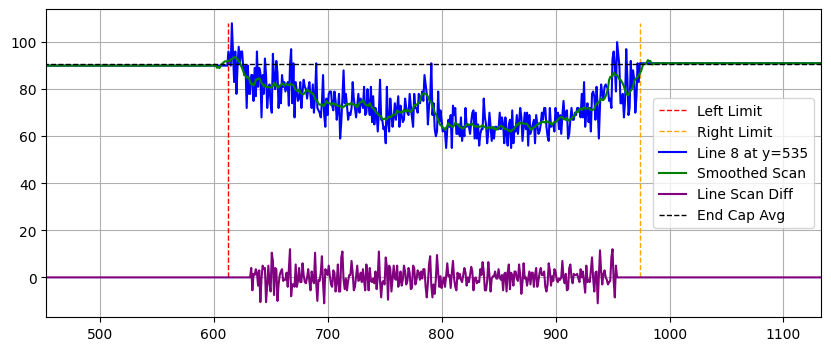

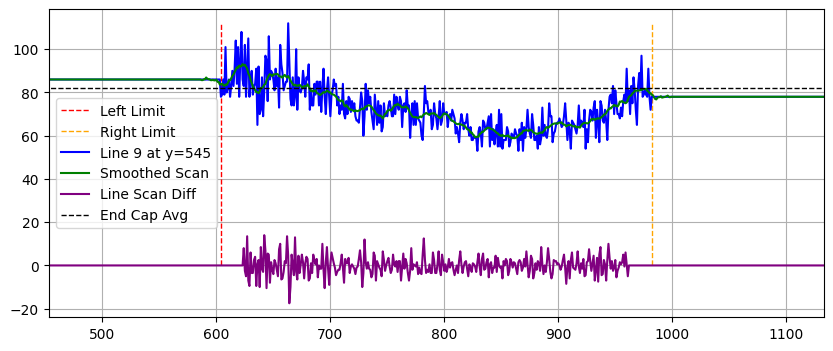

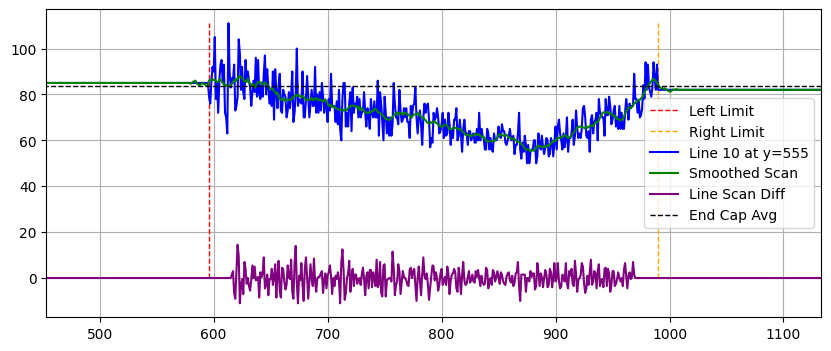

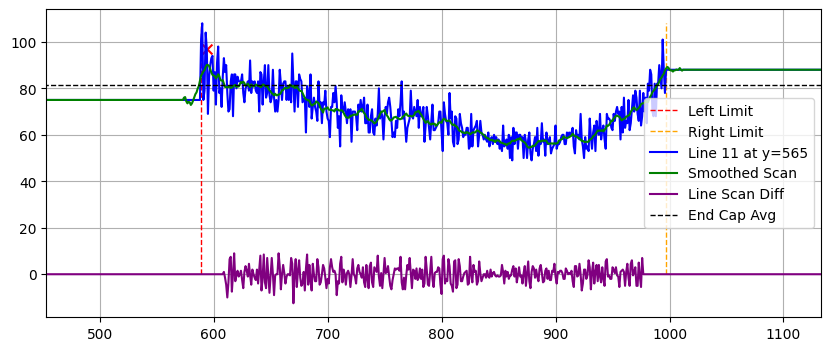

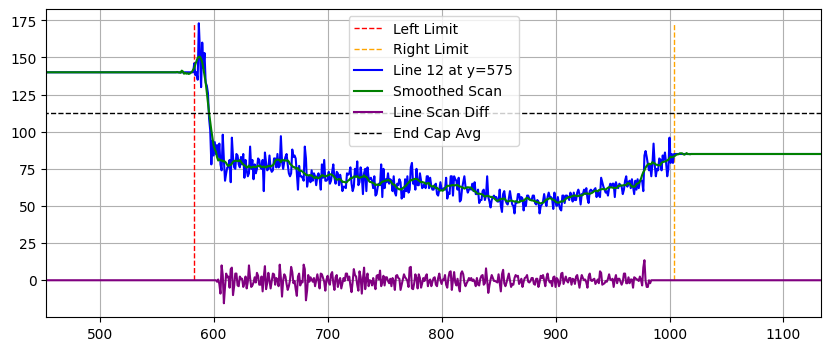

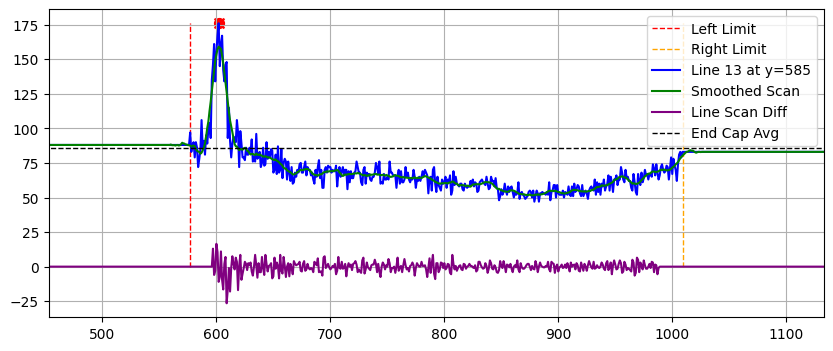

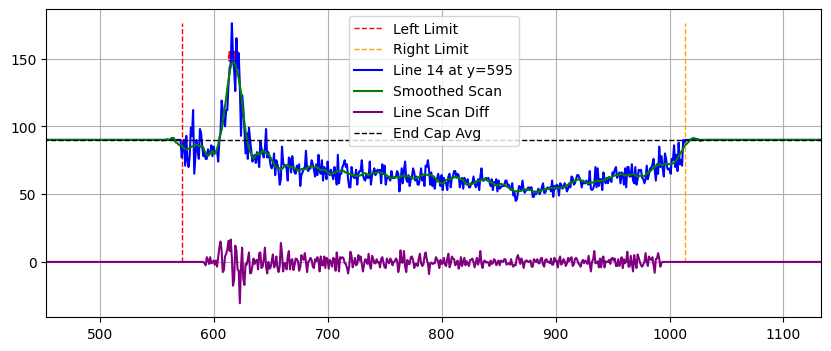

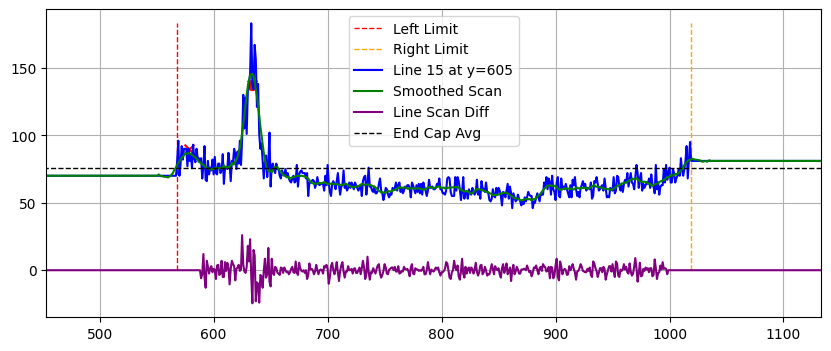

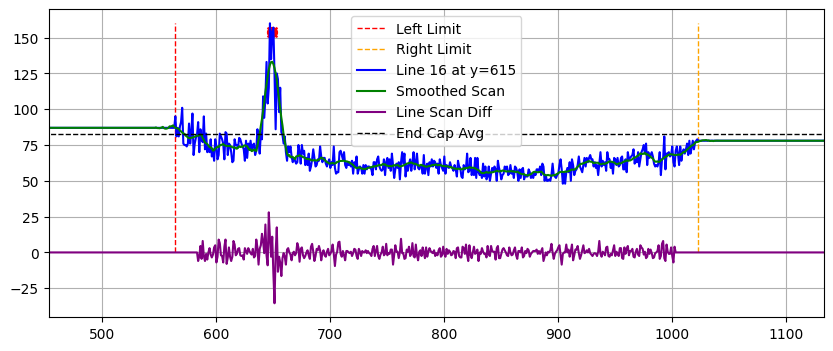

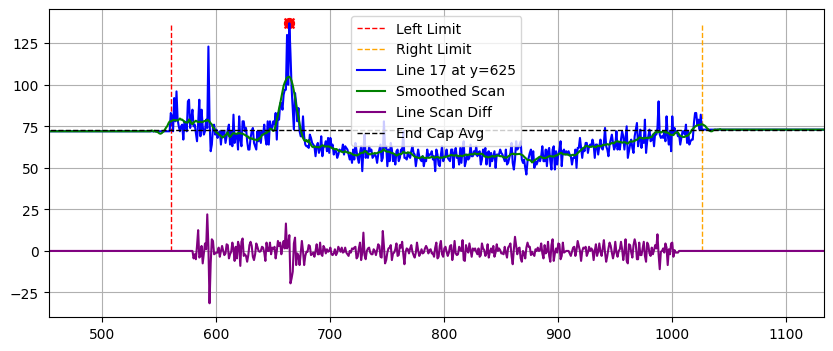

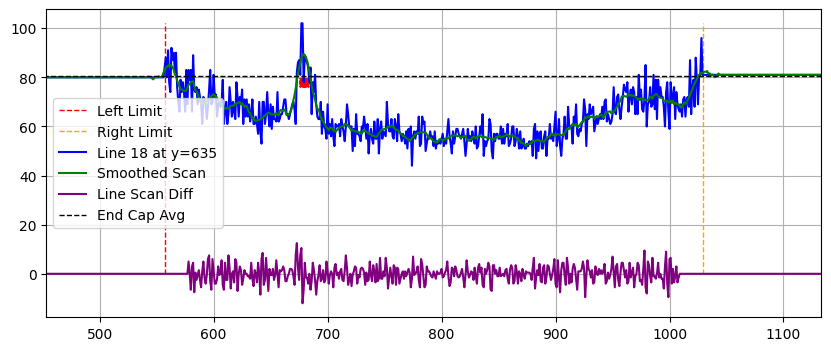

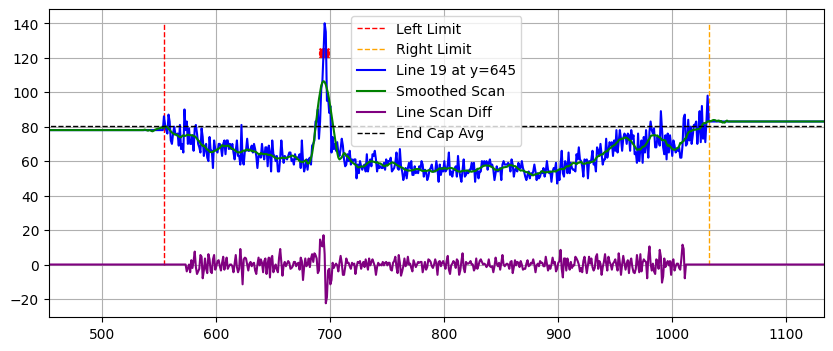

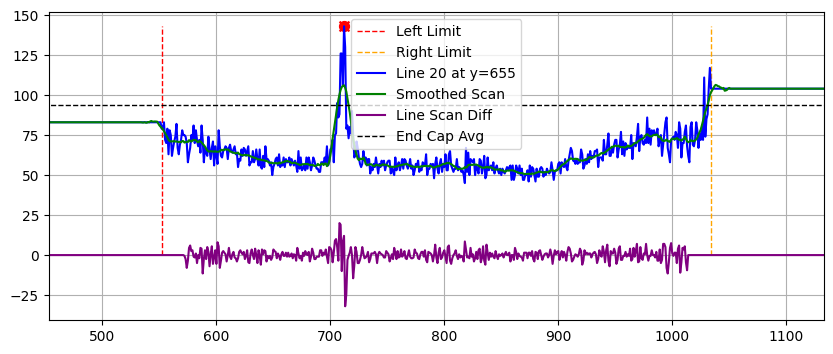

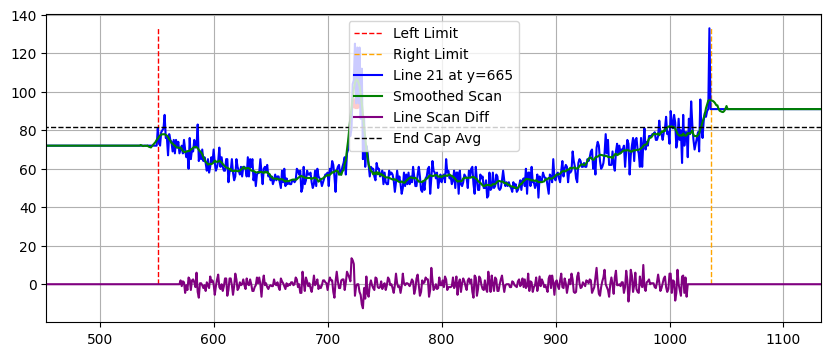

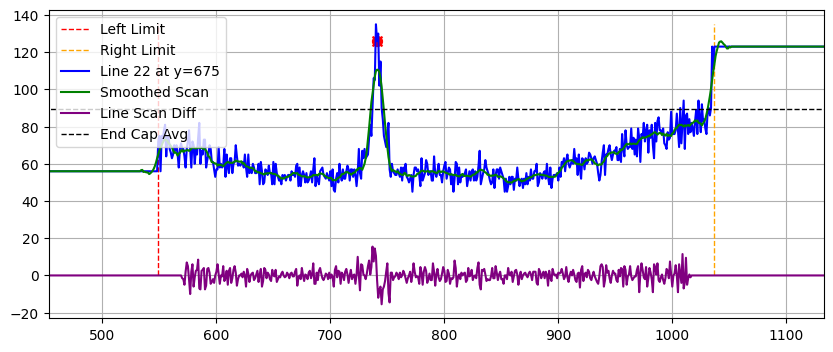

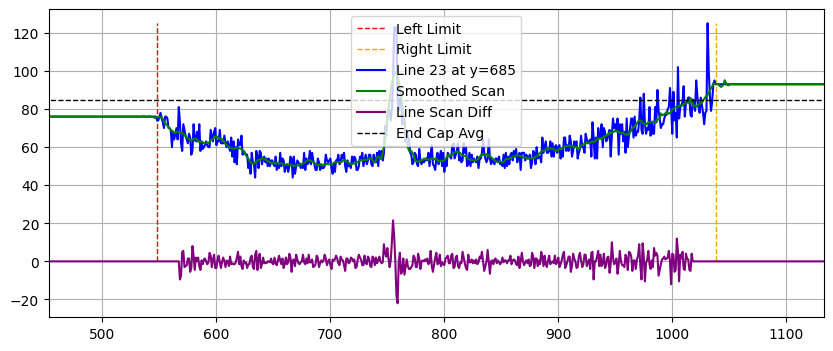

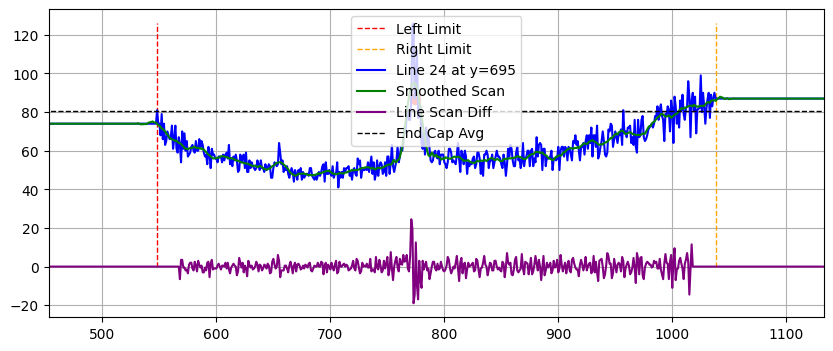

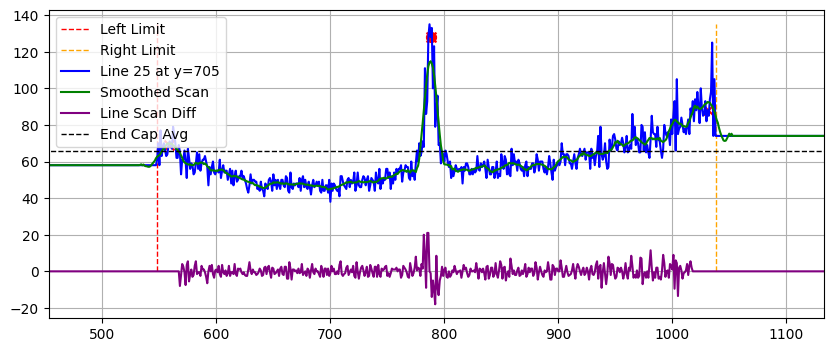

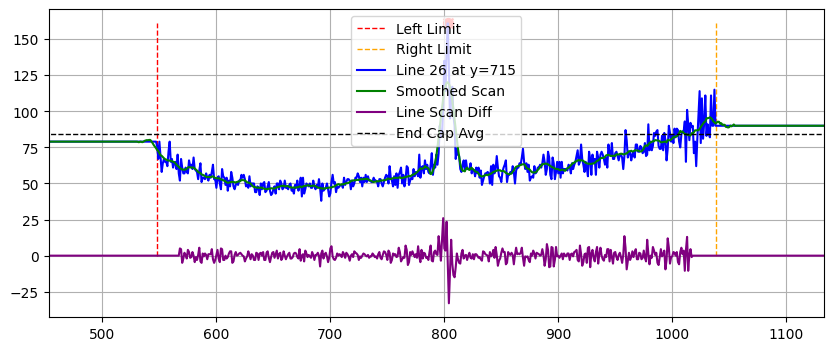

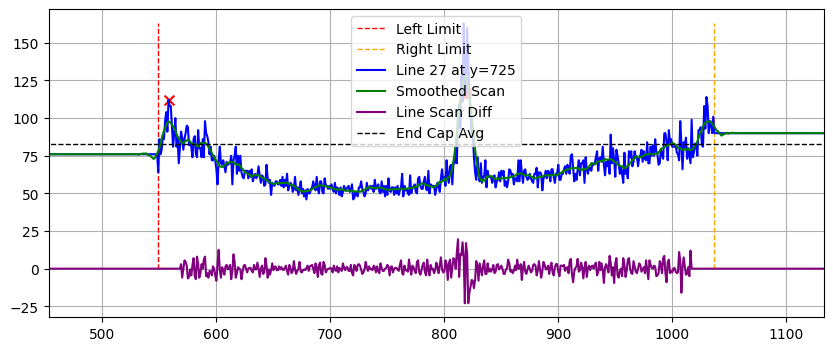

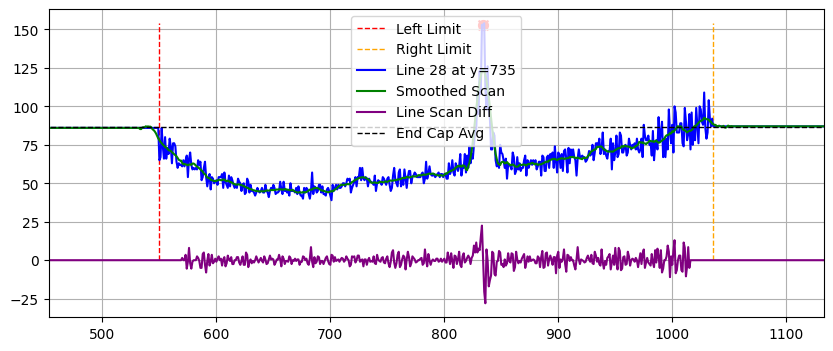

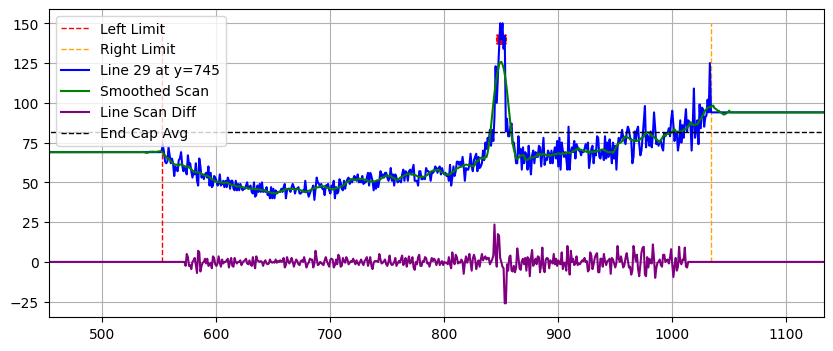

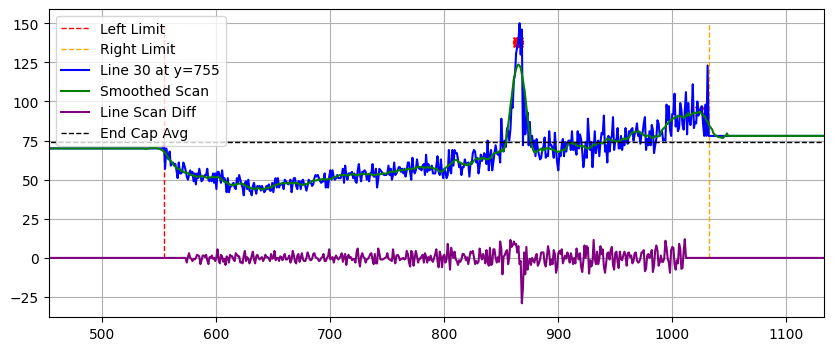

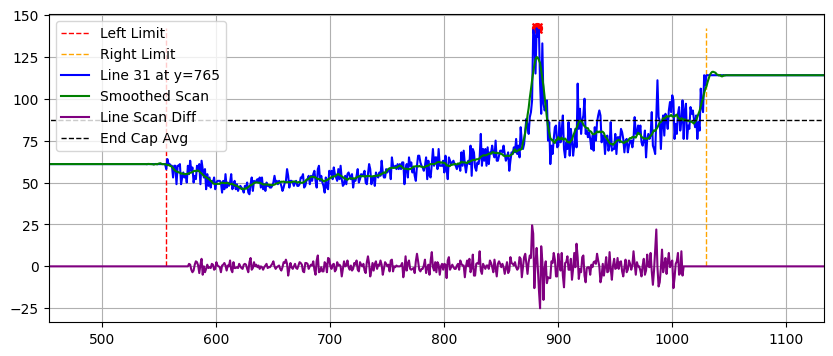

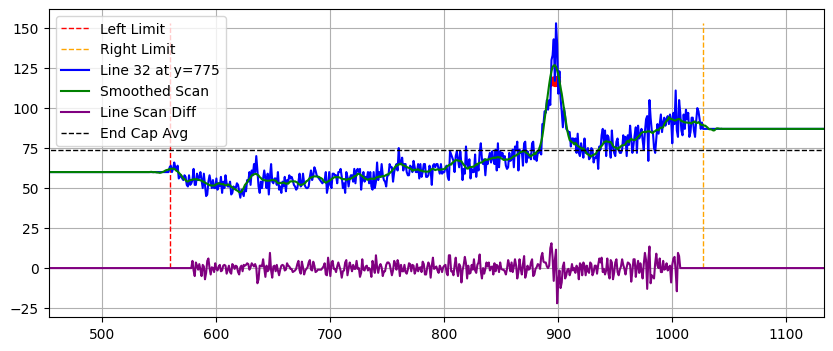

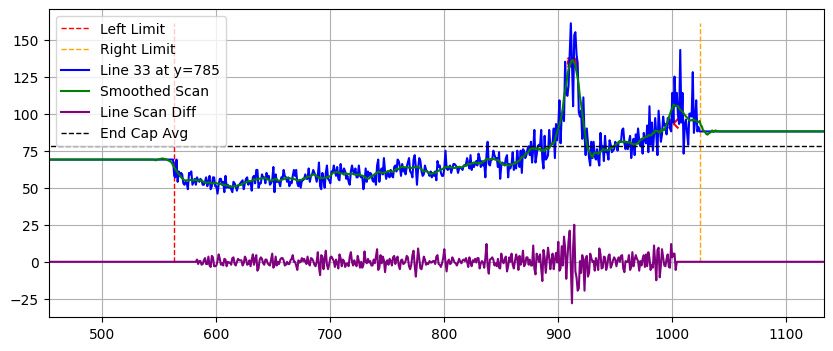

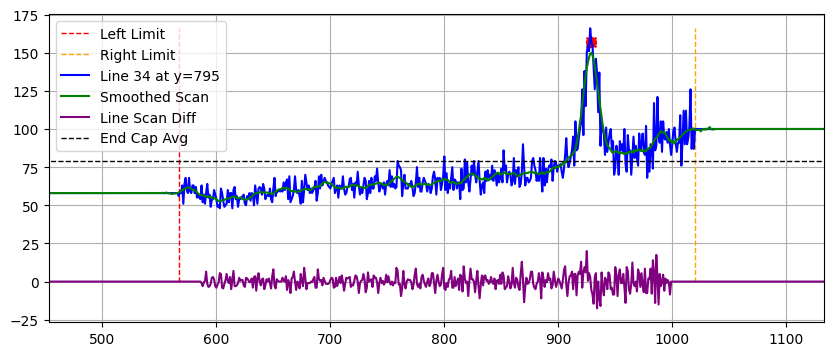

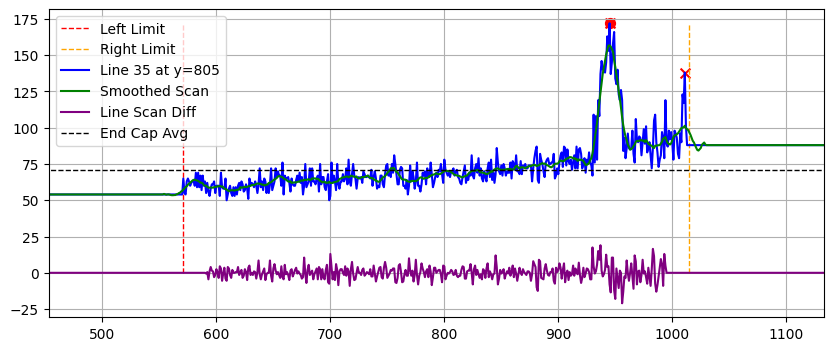

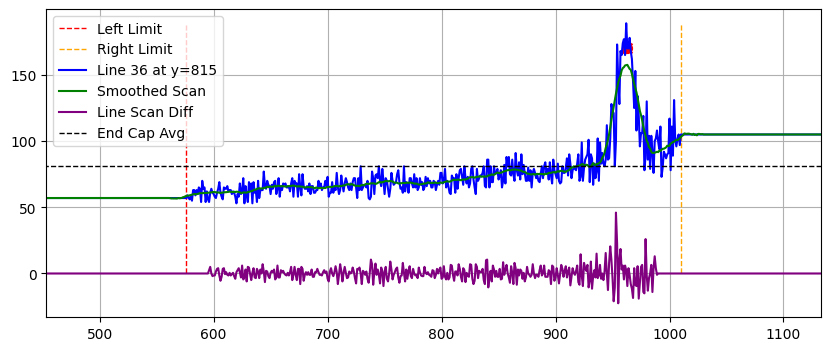

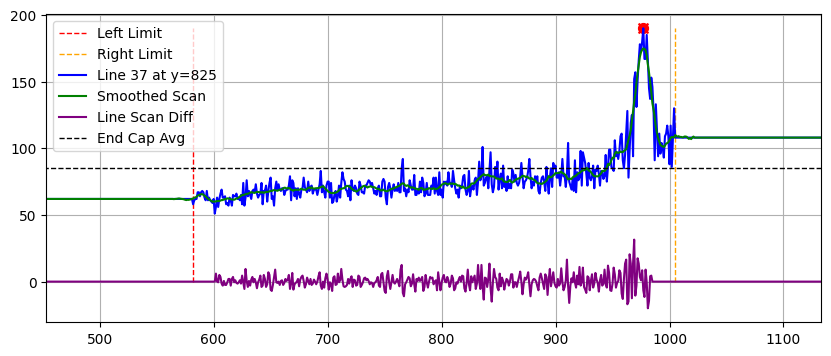

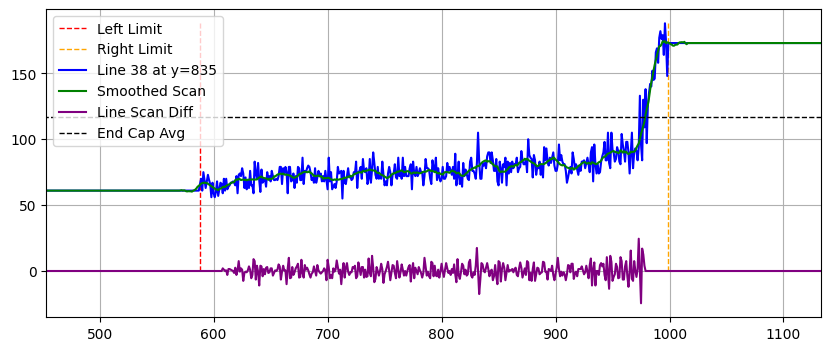

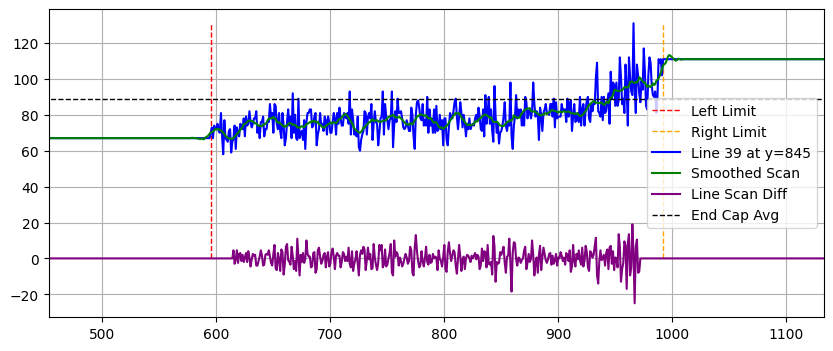

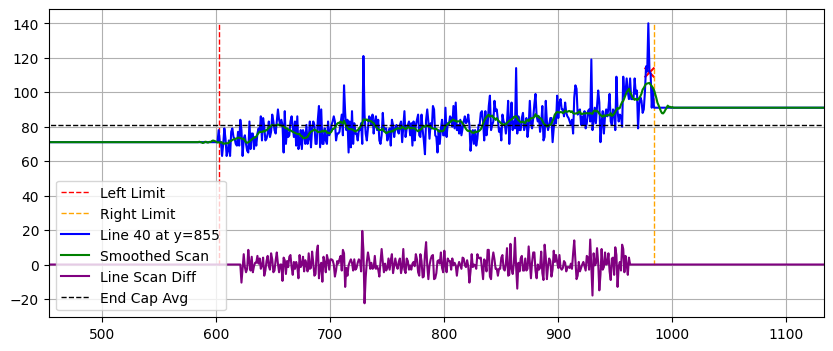

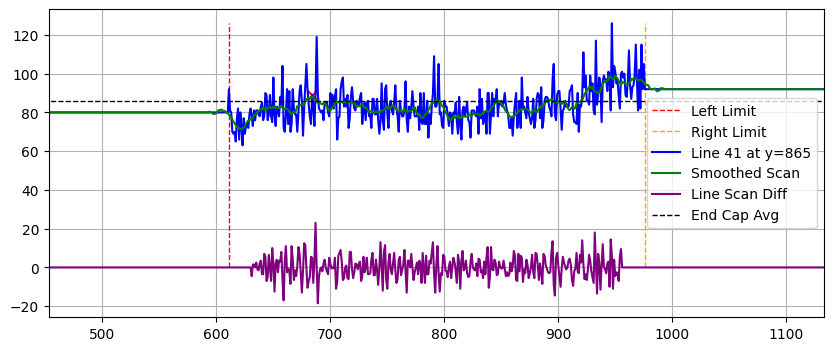

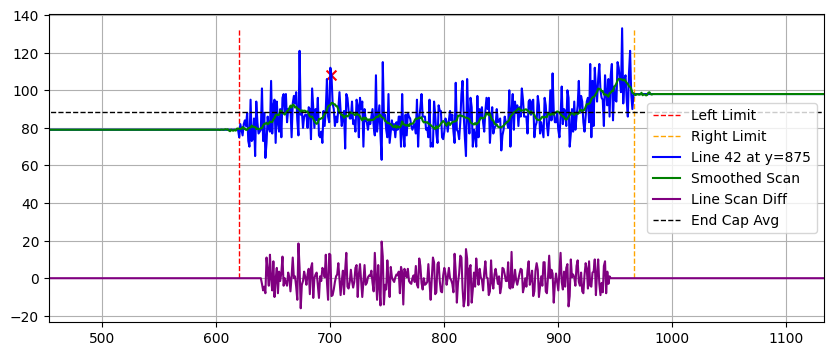

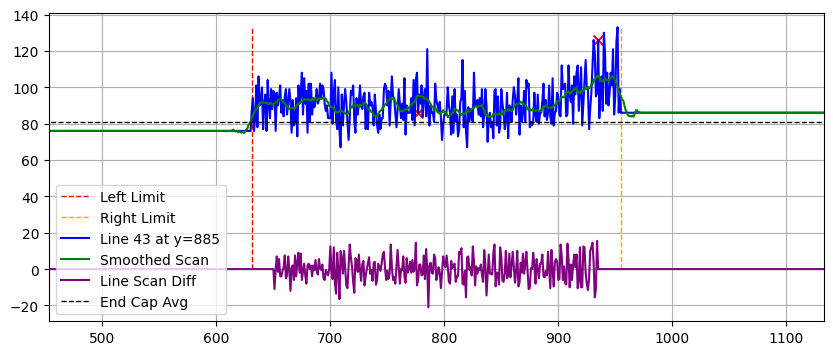

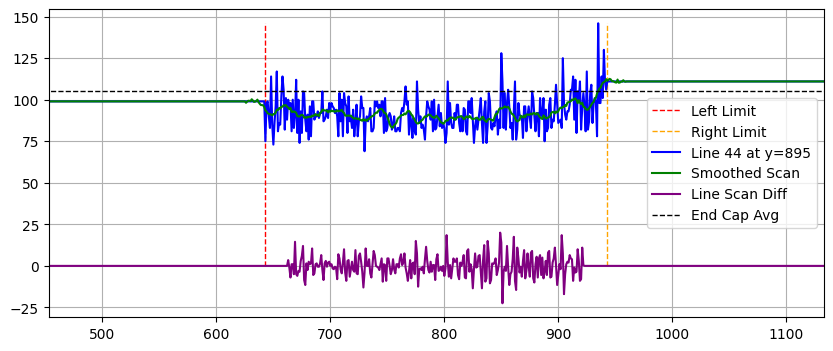

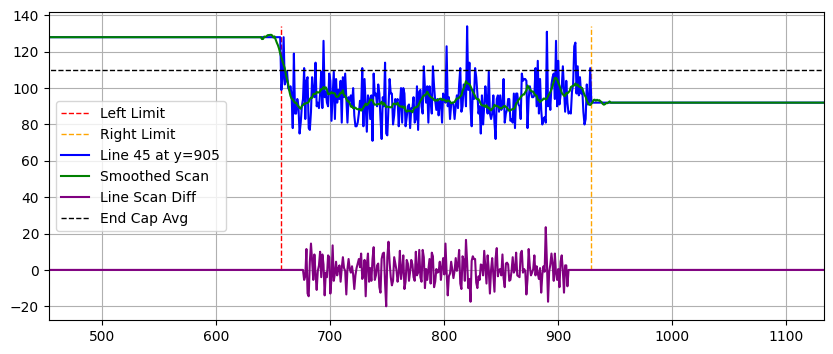

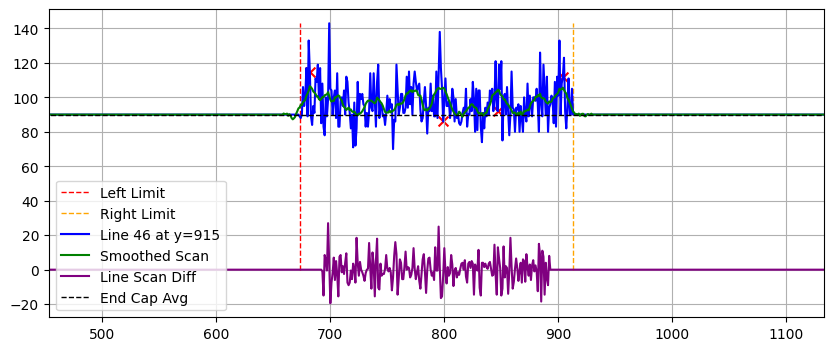

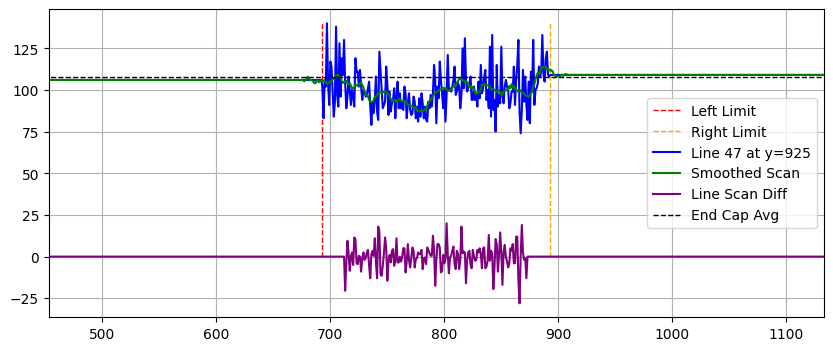

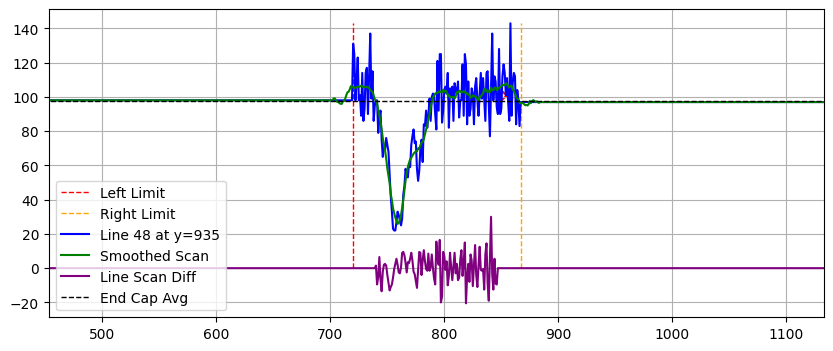

In [102]:
# img_number="00026"

# image_file_name=f"C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\Image{img_number}.BMP"
import glob
file_list = glob.glob("C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\*.BMP")
image_file_name = file_list[26]
print("Using image file:", image_file_name)
image = cv2.imread(image_file_name)


horizontal_scan_for_center_peaks(image, resolution=10,  plot=2, verbose=True)

In [ ]:
#veritcal scan function to find peaks
def vertical_scan_for_center_peaks(image, resolution, center_info=None, plot=1, verbose=False):
    
    #check if image is color or grayscale
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    
    if center_info is None:
        print("No center info provided.")
        edges=aex.horizontal_edges(gray_image, resolution=10, plot=0, verbose=False)
        center_info =aex.Center_Radius_iterations(edges, plot=False, verbose=False)

    cx, cy, r, rms = center_info[:4]
    inner_circle_rad=   r-100
    H_limit = [int(cx-inner_circle_rad), int(cx+inner_circle_rad)]
    V_limit = [int(cy-inner_circle_rad), int(cy+inner_circle_rad)]

    Horizontal_limits = [int(cx-r),int(cx+r)]
    Vertical_limits = [int(cy-r),int(cy+r)]

    

    if plot:
      fig,ax = plt.subplots(figsize=(6,10))
      ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      ax.plot(cx, cy, 'ro', label='Circle Center')
      inner_circle = plt.Circle((cx, cy), inner_circle_rad, color='blue',
                          fill=False, linestyle='--', linewidth=1, label='Inner Boundary')
      ax.add_artist(inner_circle) 
      ax.grid()


    All_peaks = []
    # start scanning lines
    for j,x in enumerate(range(H_limit[0],H_limit[1], resolution)):
        # if j<22 or j>29:
        #     continue
        if verbose:
            print(f"Line {j} at x={x}")
        full_scan = np.max(gray_image[:, x])-gray_image[:,x]
        line_scan = full_scan.copy()




        # calculate top and bottom limits for the line scan useing circle equation

        square_diff =(np.ceil(inner_circle_rad**2) - (np.floor(x - cx))**2)
        if square_diff <= 0:
            if verbose:
                print(f"Skipping line {j} at x={x} - outside inner circle")
            continue

        top_most = int(cy - np.sqrt(square_diff))
        bottom_most = int(cy + np.sqrt(square_diff))

        top_value =line_scan[top_most+20]
        bottom_value=line_scan[bottom_most-20]
        endcap_avg = (float(top_value)+float(bottom_value))/2.0
        print("top and bottom values",top_value,bottom_value)
        print("endcap avg",endcap_avg)
        line_scan[:top_most+20] = line_scan[top_most+20]
        line_scan[bottom_most-20:] =     line_scan[bottom_most-20]

        line_scan_diff = np.gradient(full_scan )
        line_scan_diff[:top_most+20]  = 0
        line_scan_diff[bottom_most-20:] = 0

        # print("line scan diff ::10",line_scan_diff[::10])

        # print("max diff",np.max(line_scan_diff), " min diff", np.min(line_scan_diff))
        # print("Std dev", np.std(line_scan_diff))

        print("max diff",np.max(line_scan_diff), " min diff", np.min(line_scan_diff))
        print("Std dev", np.std(line_scan_diff))
        window_length = 41
        polyorder = 6

        if np.std(line_scan_diff) < 1.3:
            window_length = 11
            polyorder = 6
        elif np.std(line_scan_diff) < 2:
            window_length = 31
            polyorder = 6
        elif np.std(line_scan_diff) < 3:
            window_length = 35
            polyorder = 4
        elif np.std(line_scan_diff) >= 3:
            window_length = 41
            polyorder = 3

        smooth_scan = scipy.signal.savgol_filter(line_scan, window_length=window_length, polyorder=polyorder)


        
        if plot:
            ax.vlines(x, V_limit[0], V_limit[1],
                    colors='red', linestyles='dashed', linewidth=1)

        
        if plot > 1:
            
            fig2,ax2 = plt.subplots(figsize=(10,4))
            ax2.plot(line_scan, color="blue",label=f'Line {j} at x={x}')
            ax2.plot(smooth_scan, color="green",label='Smoothed Scan')
            ax2.vlines(top_most, 0, np.max(line_scan),
                    colors='red', linestyles='dashed', linewidth=1, label='top Limit')
            ax2.vlines(bottom_most, 0, np.max(line_scan),
                    colors='orange', linestyles='dashed', linewidth=1, label='bottom Limit')

            ax2.hlines(endcap_avg, 0, len(line_scan),
                    colors='black', linestyles='dashed', linewidth=1, label='End Cap Avg')

            ax2.grid() 
            ax2.legend()
            ax2.set_xlim(Vertical_limits)

        peaks=[]

        peaks,peak_props = scipy.signal.find_peaks(smooth_scan,
                                                width=[3,45],
                                                prominence=12.5,
                                                    height=1)

        # peaks1,peak_props1 = scipy.signal.find_peaks(smooth_scan,
        #                                         width=[1,85],
        #                                         prominence=4,
        #                                         threshold=1,
        #                                             height=1)

#check to see if any peaks are very close to the left or right limits, use the peak ips
        if len(peaks)>0:
            if abs(peaks[0]-top_most)<12:
                if verbose:
                    print(f"  Removing peak at {peaks[0]} - too close to top limit {top_most}")
                peaks=peaks[1:]
                peak_props={key: peak_props[key][1:] for key in peak_props}  # Update peak_props accordingly
            if len(peaks)>0 and abs(peaks[-1]-bottom_most)<12:
                if verbose:
                    print(f"  Removing peak at {peaks[-1]} - too close to bottom limit {bottom_most}")
                peaks=peaks[:-1]
                peak_props={key: peak_props[key][:-1] for key in peak_props}  # Update peak_props accordingly
            # check for prominence/width ratio
            prominences = peak_props['prominences']
            widths = peak_props['widths']
            squat_ratio = prominences/widths
            print(squat_ratio)
            #drop peaks that have a squat ratio < 1.3
            valid_peaks_mask = squat_ratio >= 1.0
            peaks = peaks[valid_peaks_mask]
            peak_props = {key: peak_props[key][valid_peaks_mask] for key in peak_props}



        if verbose:
            print(f"  Found {len(peaks)} peaks at x-positions: {peaks}") 
            for key in peak_props:
                print(f"    {key}: {peak_props[key]}")  

        # print(peaks1)
        # for key in peak_props1:
        #     print(f"    {key}: {peak_props1[key]}")


        if len(peaks) > 0:
            if plot > 1:
                ax2.scatter(peaks, line_scan[peaks], color='red', s=50, label='Detected Peaks')
            if plot >= 1:
                ax.scatter(np.full_like(peaks, x), peaks, color='cyan', s=20, label='Detected Peaks')
        # if len(peaks1) > 0:
        #     ax2.scatter(peaks1, smooth_scan[peaks1], color='red', s=50, label='All Detected Peaks')
            
        #If more then two peaks are found pick the best two based on prominence
        if len(peaks) > 2:
            prominences = peak_props['prominences']
            top_two_indices = np.argsort(prominences)[-2:]
            peaks = peaks[top_two_indices]


        All_peaks.append(np.column_stack((np.full_like(peaks, x), peaks)))

    return np.vstack(All_peaks)
            




Using image file: C:\Users\Jason.Bane\Documents\Nautilus\DOE_stage\code_trials\images\Image__2025-09-30__10-41-15.bmp
No center info provided.
Line 0 at x=553
Skipping line 0 at x=553 - outside inner circle
Line 1 at x=563
top and bottom values 58 50
endcap avg 54.0
max diff 20.5  min diff -21.5
Std dev 1.4863540754140647
[4.91201294]
  Found 1 peaks at x-positions: [727]
    peak_heights: [101.6678065]
    prominences: [47.45976755]
    left_bases: [717]
    right_bases: [750]
    widths: [9.66197935]
    width_heights: [77.93792273]
    left_ips: [721.97064041]
    right_ips: [731.63261976]
Line 2 at x=573
top and bottom values 83 56
endcap avg 69.5
max diff 12.5  min diff -18.0
Std dev 1.4783858854808134
[2.7762908]
  Found 1 peaks at x-positions: [726]
    peak_heights: [80.51183778]
    prominences: [25.66864101]
    left_bases: [699]
    right_bases: [737]
    widths: [9.24566007]
    width_heights: [67.67751727]
    left_ips: [721.78417685]
    right_ips: [731.02983692]
Line 3 a

C:\Users\Jason.Bane\AppData\Local\Temp\ipykernel_2916\3627302812.py:105: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig2,ax2 = plt.subplots(figsize=(10,4))


[3.15715953]
  Found 1 peaks at x-positions: [741]
    peak_heights: [99.55310949]
    prominences: [41.9047622]
    left_bases: [667]
    right_bases: [755]
    widths: [13.27293152]
    width_heights: [78.60072839]
    left_ips: [734.68157261]
    right_ips: [747.95450413]
Line 30 at x=853
top and bottom values 73 83
endcap avg 78.0
max diff 27.0  min diff -28.0
Std dev 2.8541708941574533
[4.01806888]
  Found 1 peaks at x-positions: [748]
    peak_heights: [112.35910297]
    prominences: [54.23418343]
    left_bases: [668]
    right_bases: [761]
    widths: [13.49757433]
    width_heights: [85.24201126]
    left_ips: [740.69297759]
    right_ips: [754.19055192]
Line 31 at x=863
top and bottom values 82 82
endcap avg 82.0
max diff 29.0  min diff -27.5
Std dev 2.9551983388974454
[3.55325014]
  Found 1 peaks at x-positions: [753]
    peak_heights: [111.29062568]
    prominences: [46.81191084]
    left_bases: [655]
    right_bases: [766]
    widths: [13.17439219]
    width_heights: [87.8

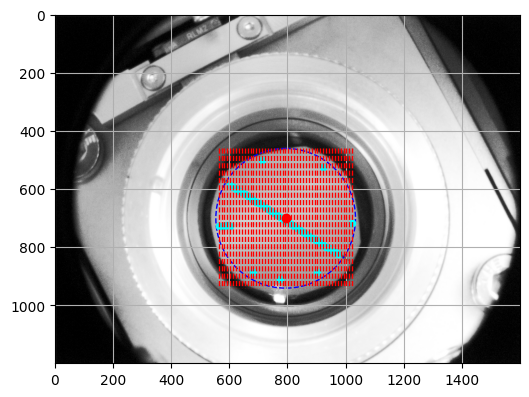

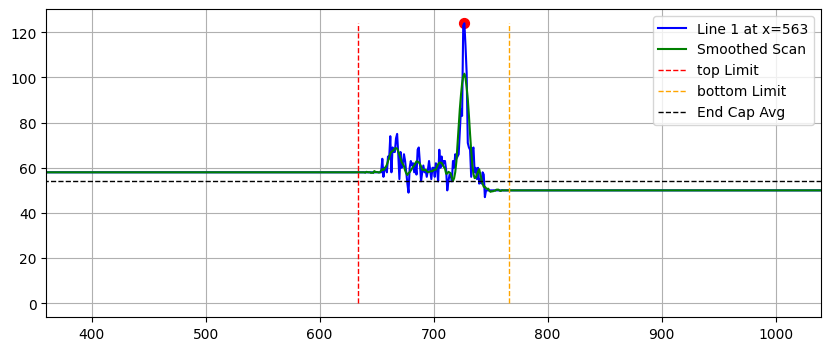

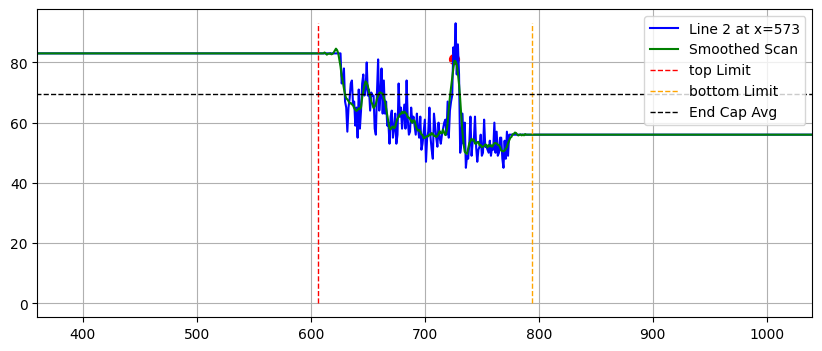

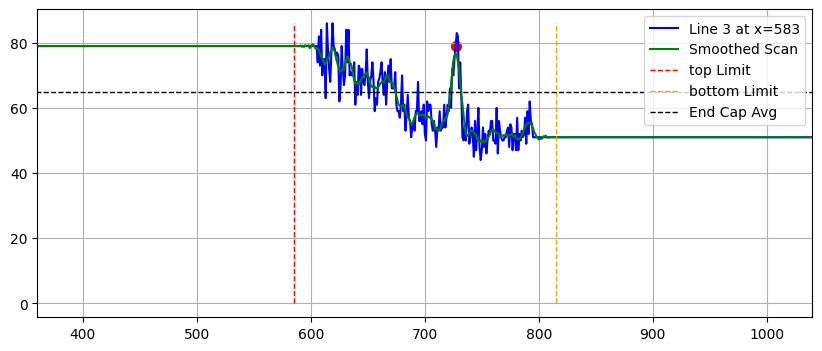

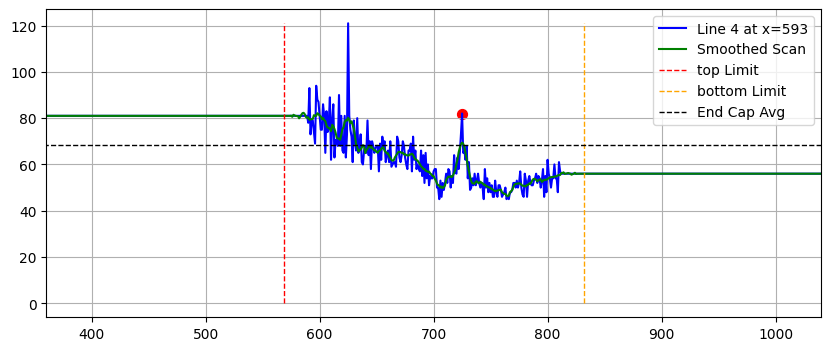

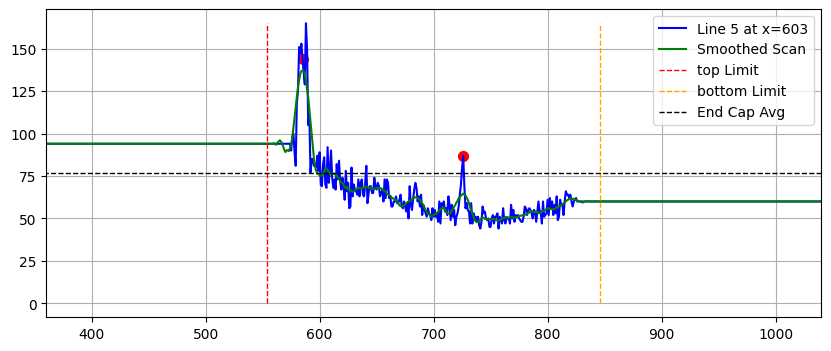

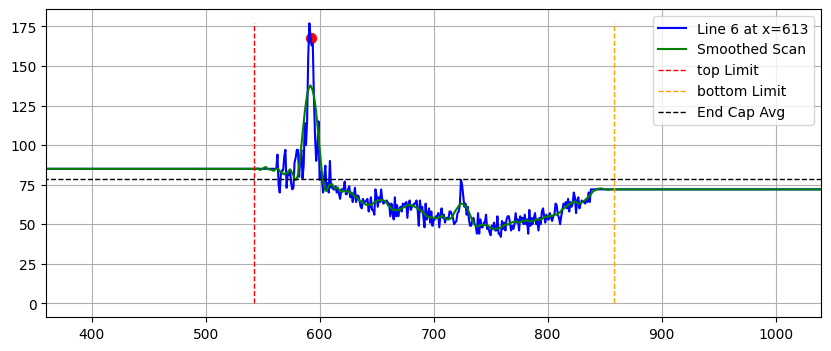

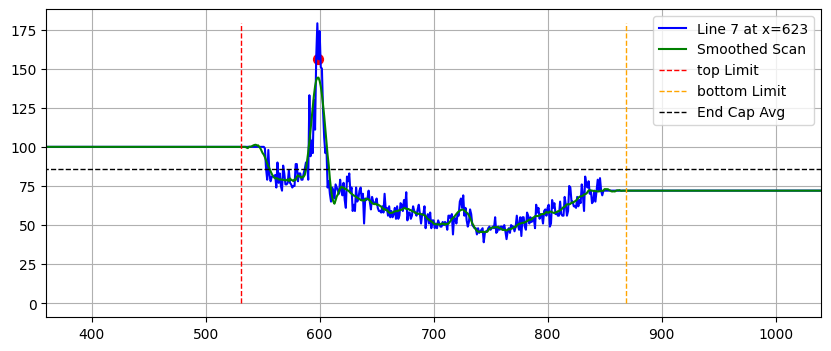

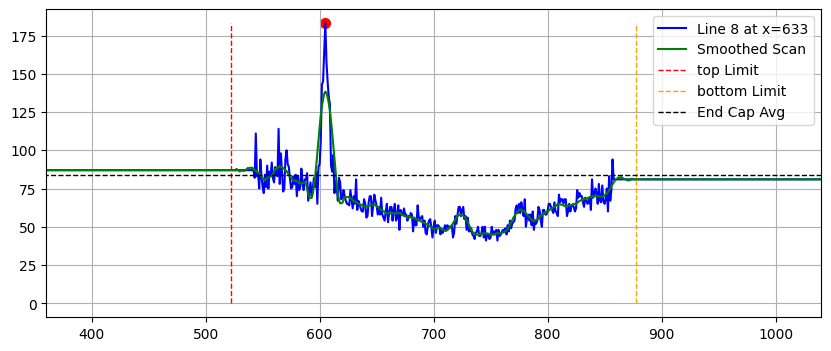

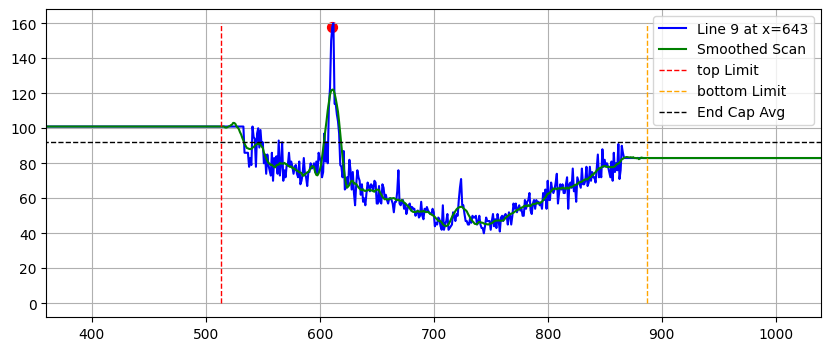

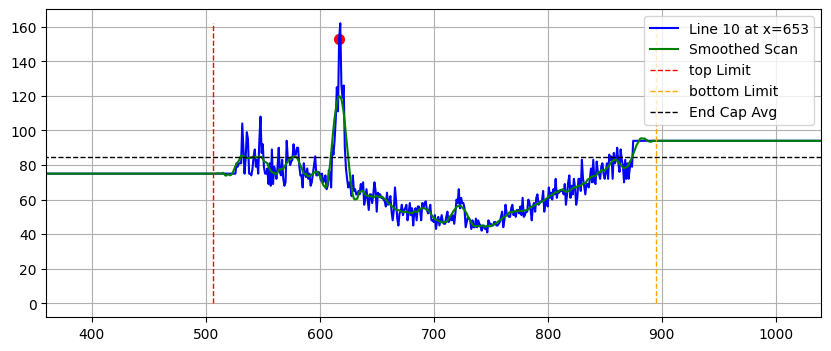

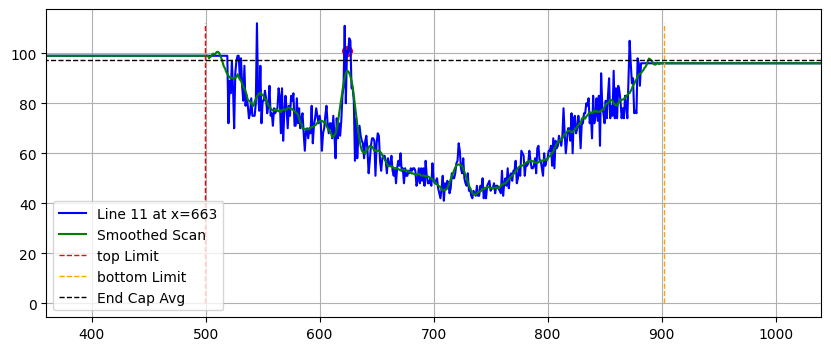

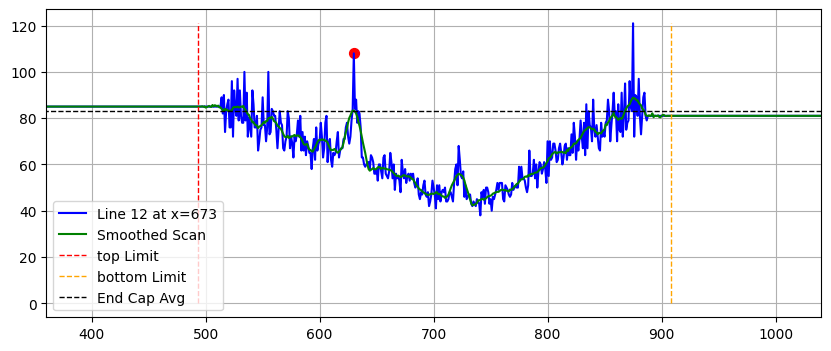

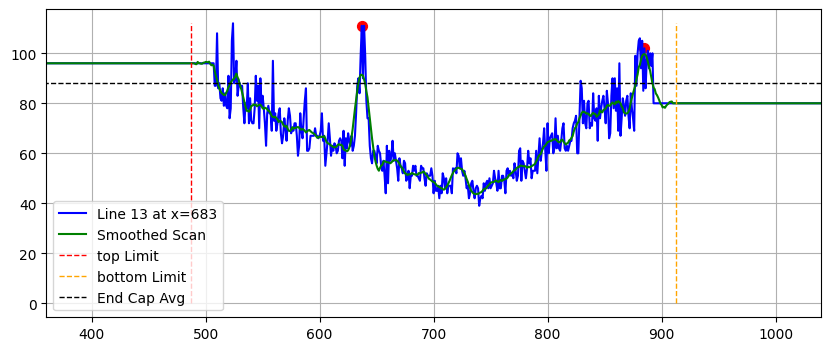

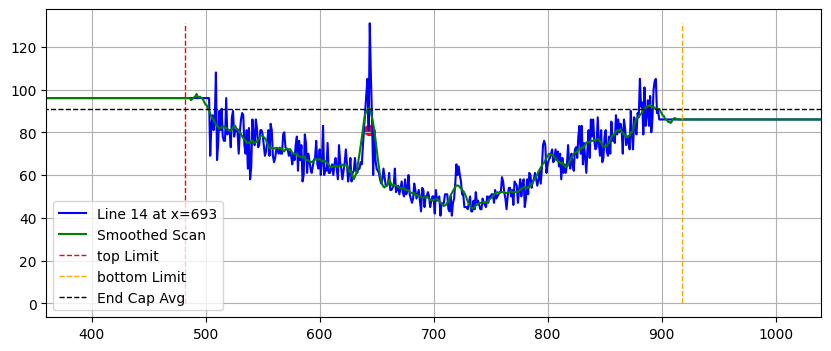

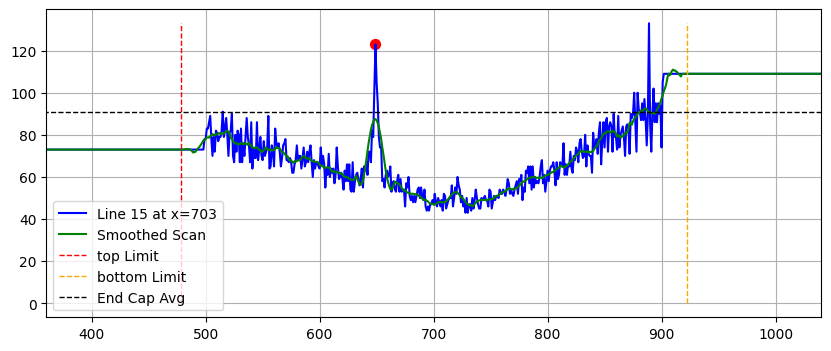

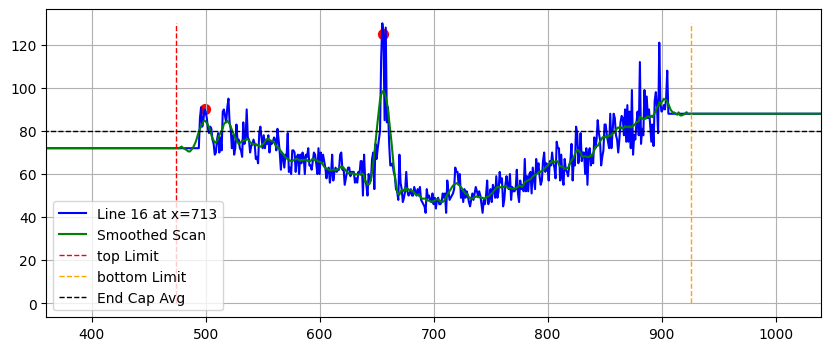

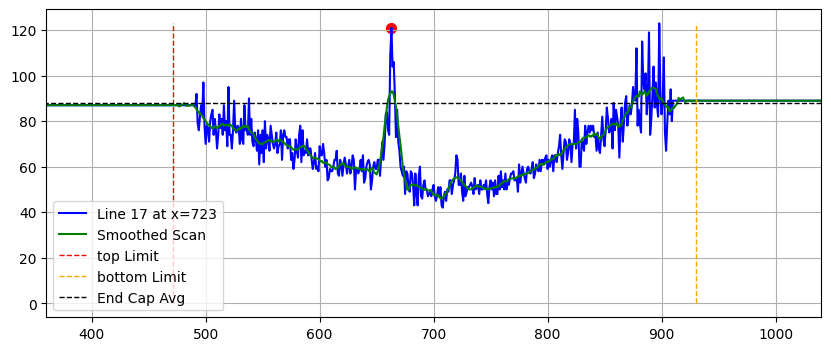

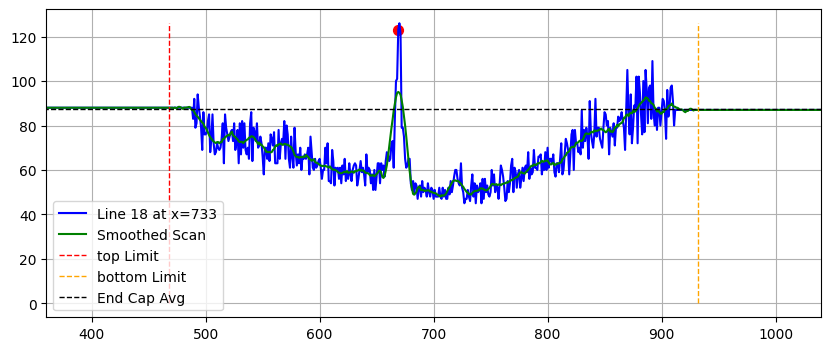

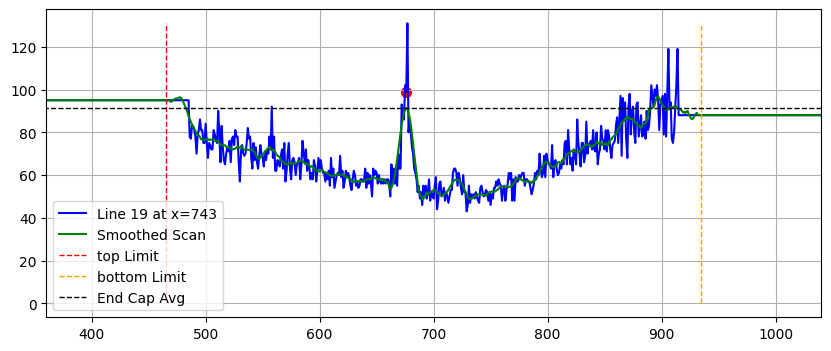

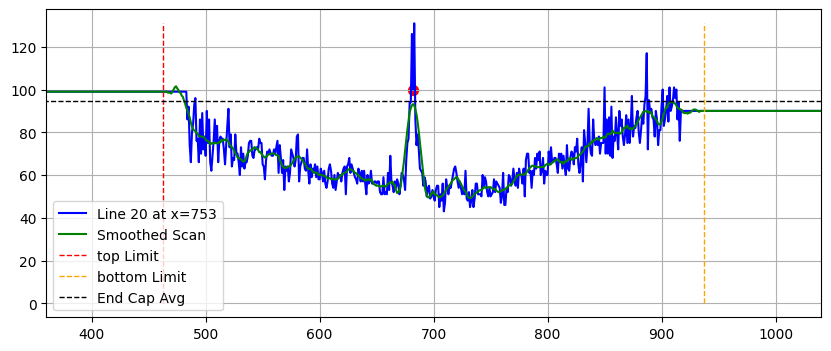

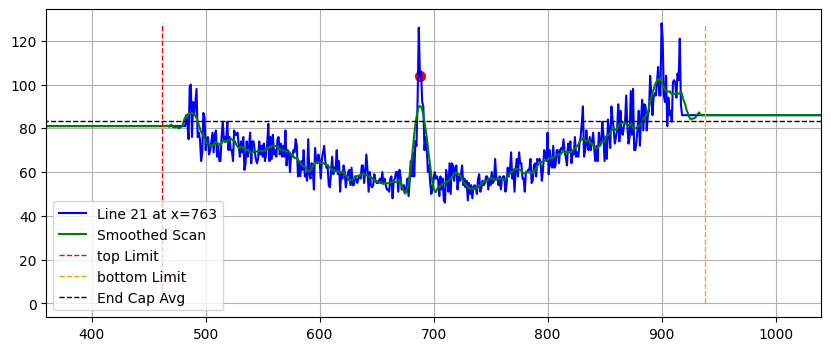

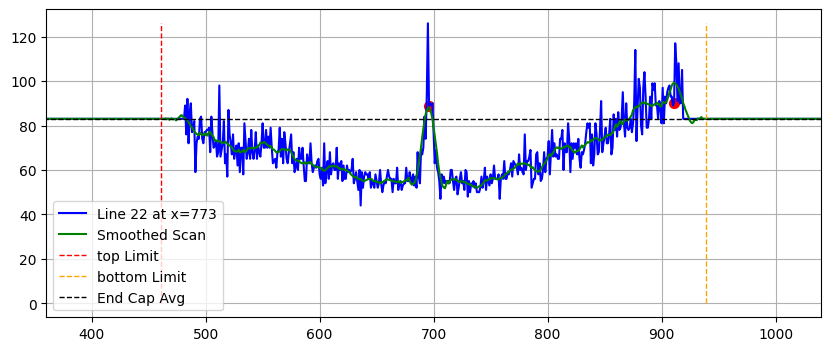

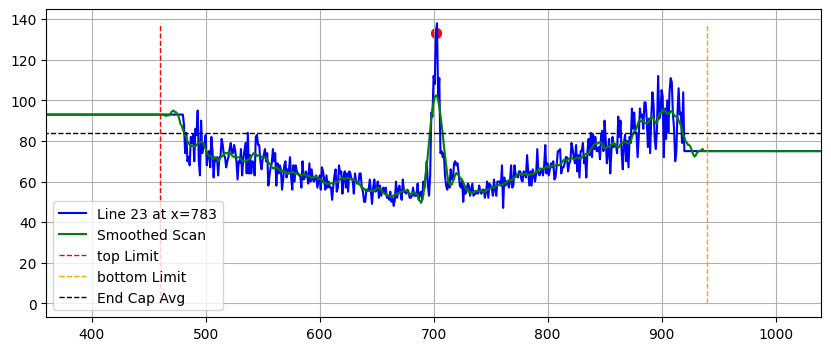

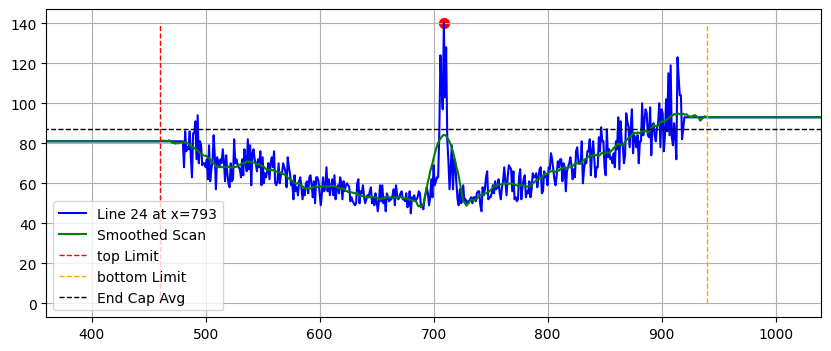

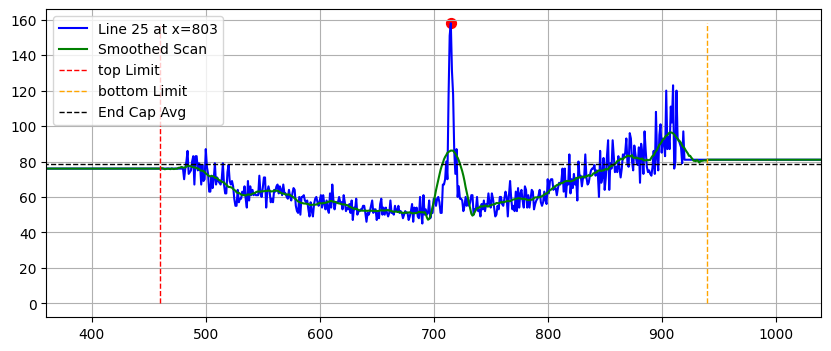

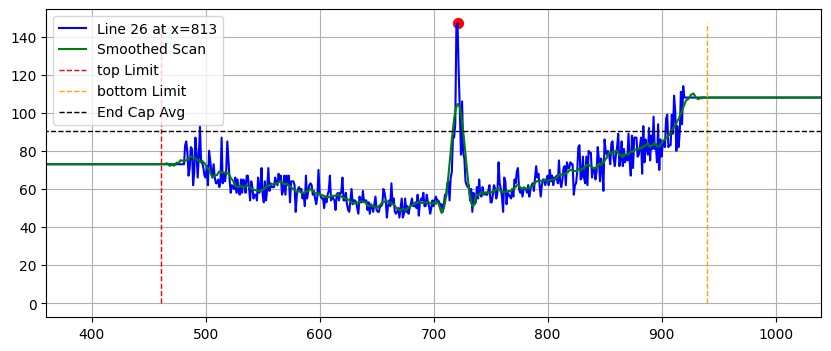

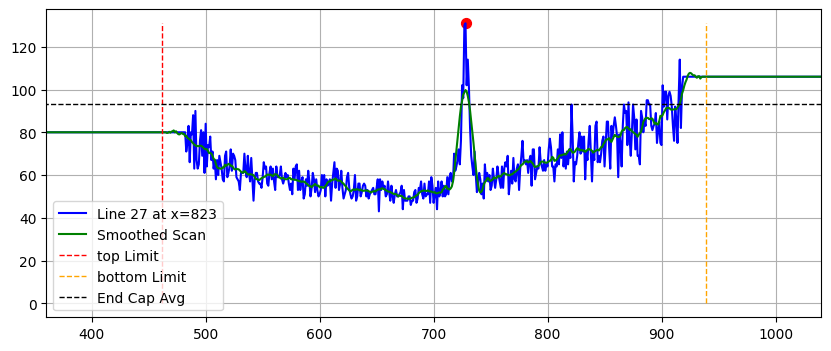

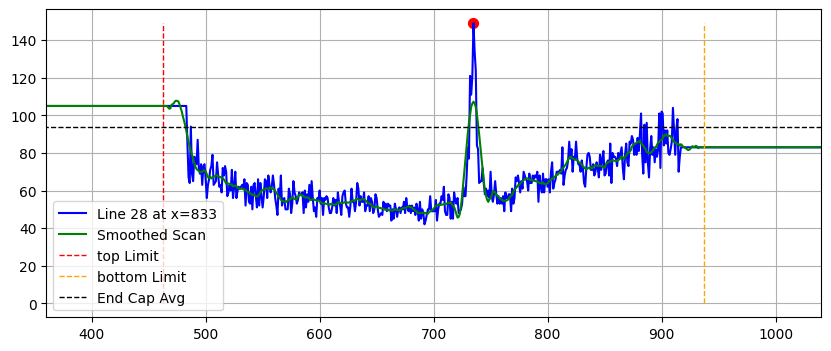

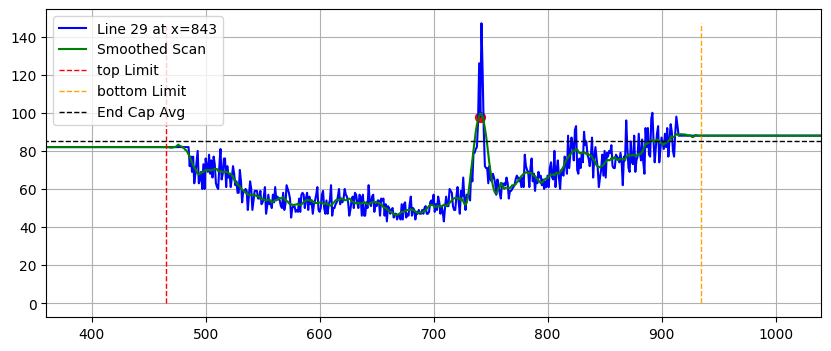

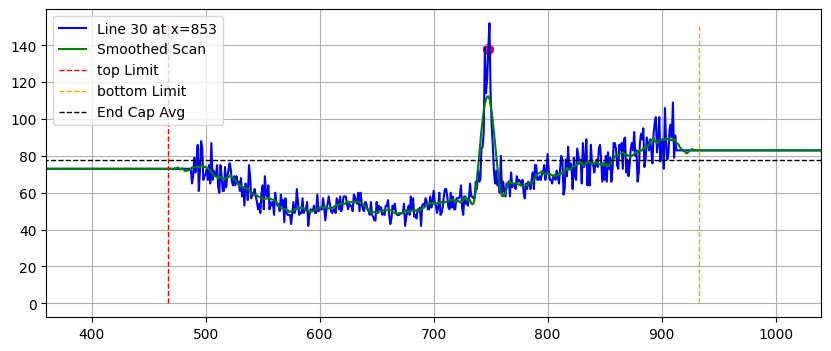

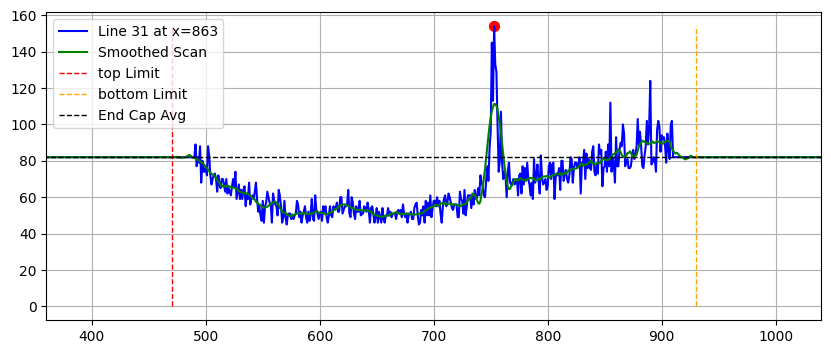

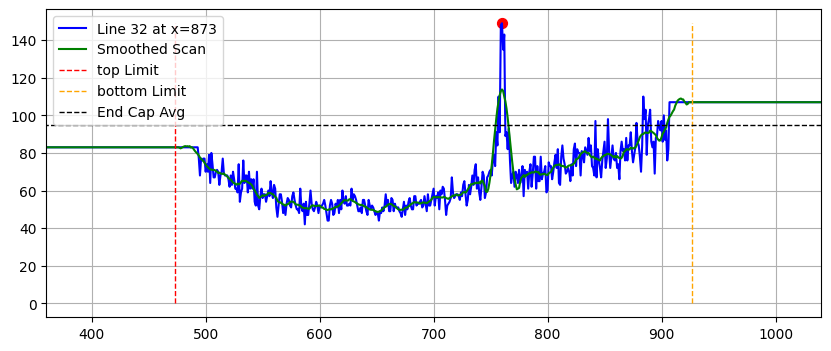

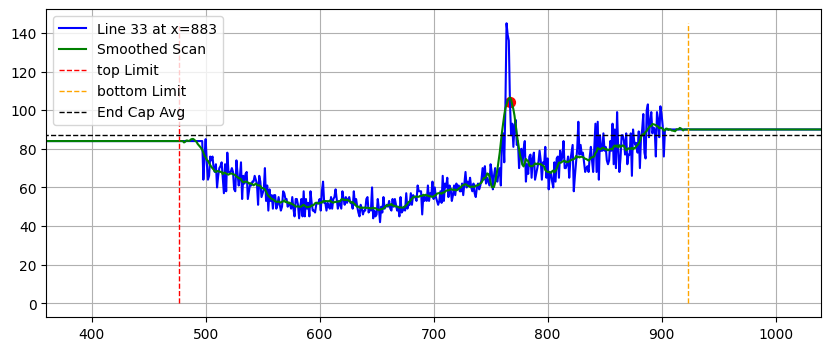

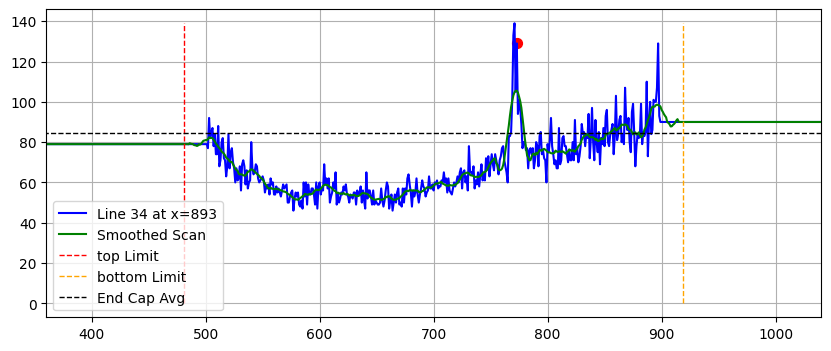

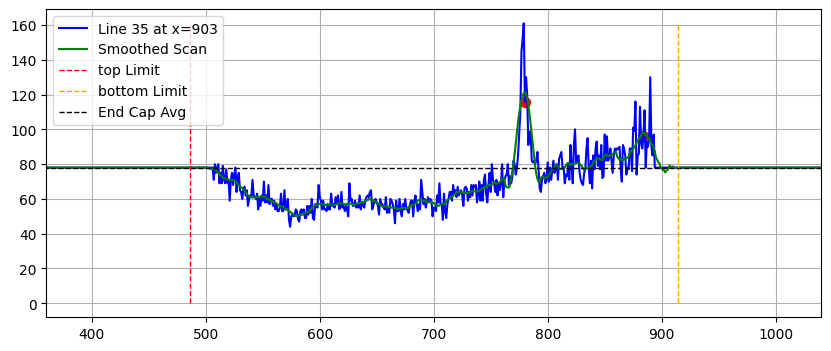

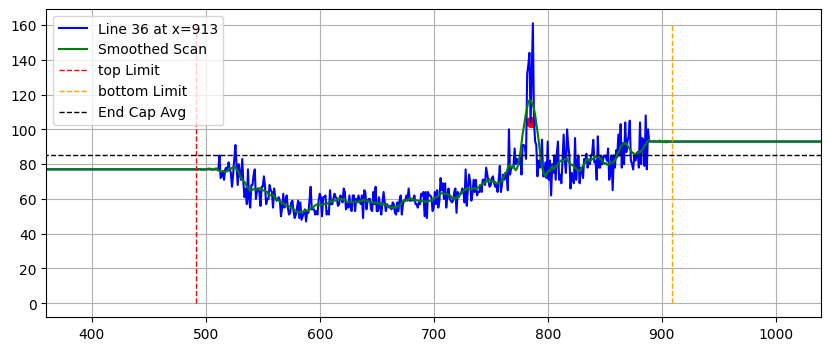

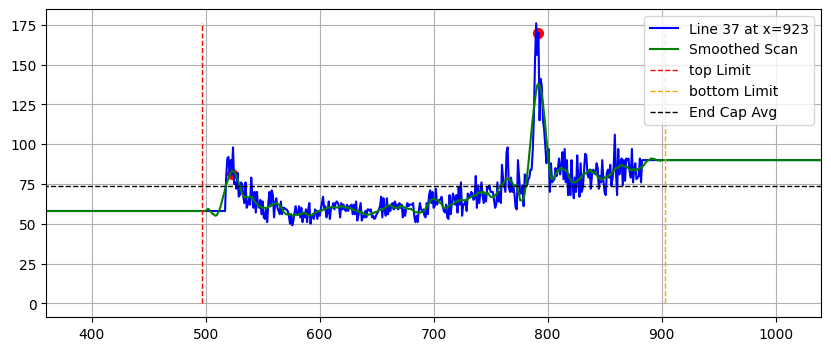

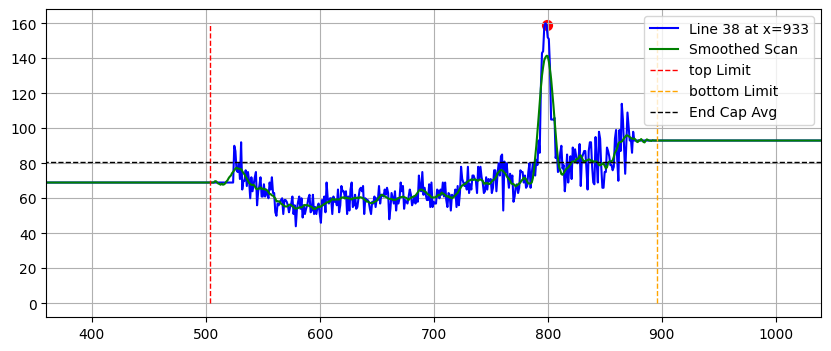

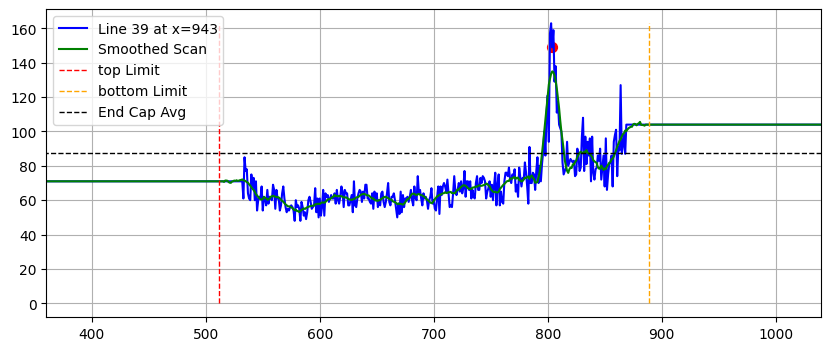

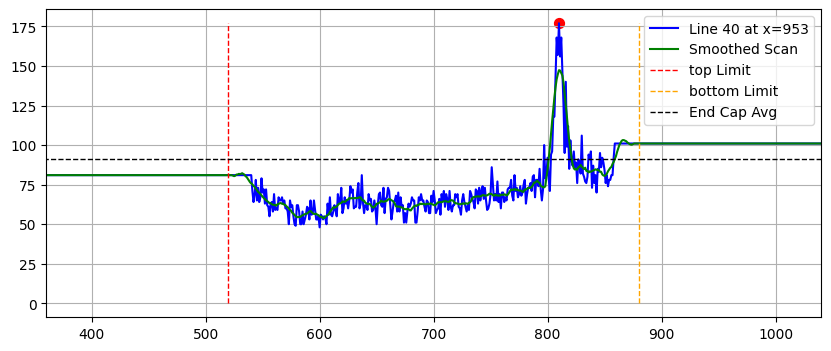

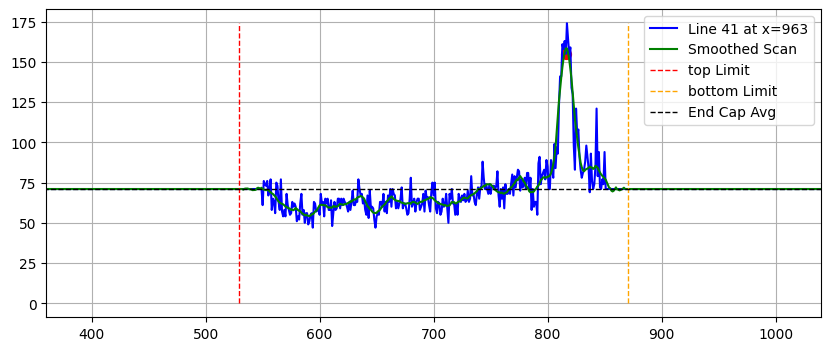

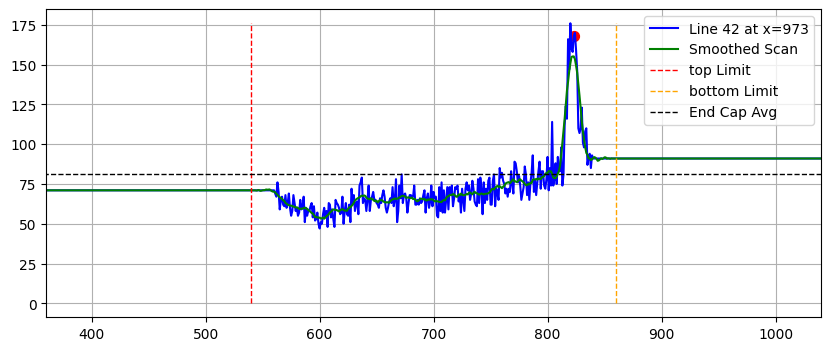

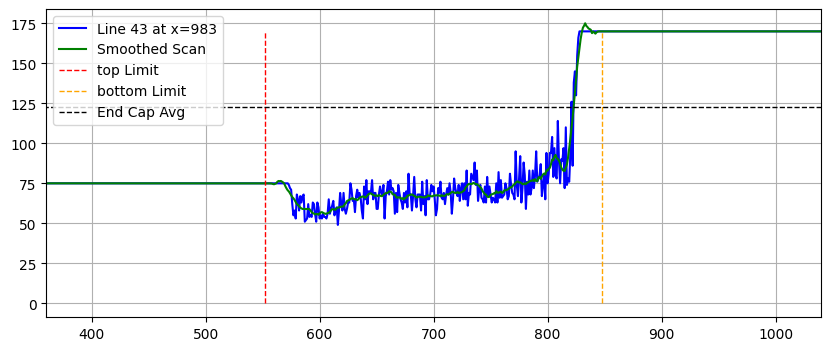

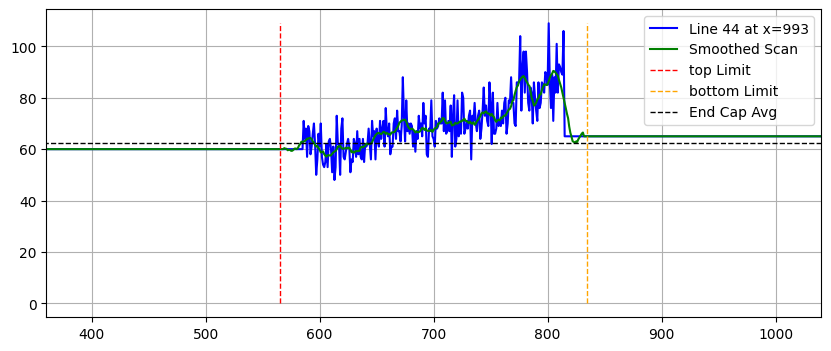

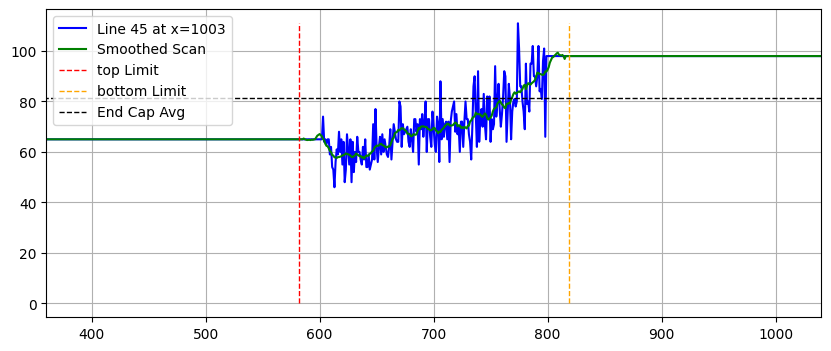

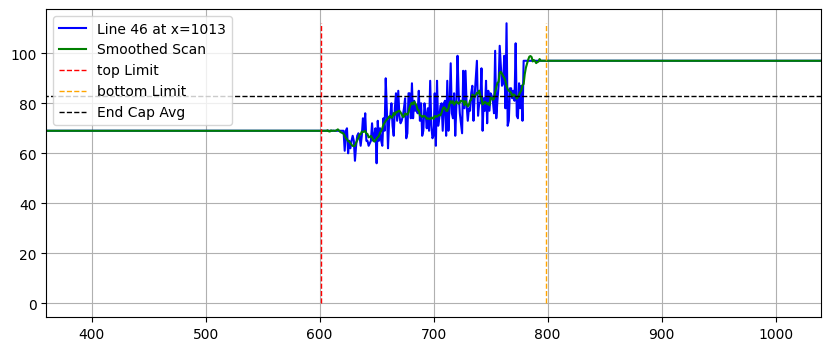

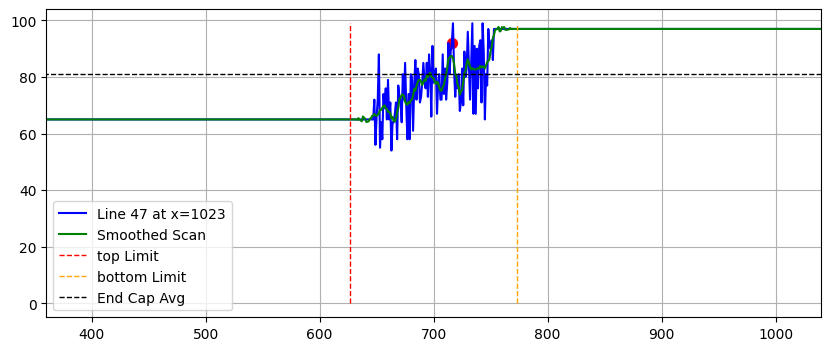

In [116]:
import glob
file_list = glob.glob("C:\\Users\\Jason.Bane\\Documents\\Nautilus\\DOE_stage\\code_trials\\images\\*.BMP")
image_file_name = file_list[26]
print("Using image file:", image_file_name)
image = cv2.imread(image_file_name)



Vertical_scan = vertical_scan_for_center_peaks(image, resolution=10, plot=2, verbose=True)